In [1]:
import inspyred
from inspyred import ec, benchmarks

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import pandas as pd
import re
import itertools
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import pickle
import time
import psutil
import gc
import random
import pynvml

from scipy.stats import chisquare, kstest
import math

random.seed(42)
np.random.seed(42)

In [2]:
# Function to clean folder names
def clean_folder_name(folder_name):
    # Remove invalid characters
    cleaned_name = re.sub(r'[<>:"/\\|?*]', '', folder_name)
    # Remove trailing dots and spaces
    cleaned_name = cleaned_name.rstrip('. ')
    return cleaned_name

def CPU_monitor_memory_usage():
    memory_info = psutil.virtual_memory()
    memory_usage = memory_info.percent
        
    print(f"CPU Current memory usage: {memory_usage}%")

    if memory_usage >= 100:
        print("CPU Memory usage is too high. Pausing execution...")
        gc.collect()  # Trigger garbage collection manually
        while memory_usage > 30:
            time.sleep(10)
            memory_info = psutil.virtual_memory()
            memory_usage = memory_info.percent
        print("CPU Memory usage is low enough. Resuming execution...")

    # time.sleep(5)

def monitor_gpu_memory():
    # Initialize NVML
    pynvml.nvmlInit()
    
    try:
        # Get handle for the first GPU
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)

        # Get memory info
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        total_memory = mem_info.total
        used_memory = mem_info.used

        # Calculate the percentage of GPU memory used
        memory_usage = (used_memory / total_memory) * 100
        print(f"Current GPU memory usage: {memory_usage:.2f}%")

        # Check if memory usage is too high
        if memory_usage >= 95:
            print("GPU memory usage is too high. Pausing execution...")
            while memory_usage > 30:
                time.sleep(10)
                mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
                used_memory = mem_info.used
                memory_usage = (used_memory / total_memory) * 100
            print("GPU memory usage is low enough. Resuming execution...")

    finally:
        # Clean up
        pynvml.nvmlShutdown()

In [3]:
def CatList(cat_, list_, type_ = "and"):
        if type_ == "and":
            return cat_ in list_
        elif type_ == "or":
            return cat_ not in list_
        else:
            return True
def cats_used(max_cat_others, data, output_cat, min_cats = 2):
    if max_cat_others > 0:
        cats_values = (data[output_cat].value_counts()/data.shape[0])*100
        sum_perc = 0
        cats_ = []
        for i in range(len(cats_values)):
            if len(cats_) < min_cats or sum_perc < (100-max_cat_others):
                cats_.append(str(cats_values.index[i]))
                sum_perc = sum_perc + cats_values[i]
            else:
                break

    else:
        cats_ = list(pd.unique(data[output_cat].tolist()))

    return cats_

def cats_levels(data, max_cat_others, output_cat, min_cats,prev_cats= {}):
    cats_to_use = []
    if len(list(prev_cats.keys())) != 0:
        for cat_name in prev_cats.keys():
            print(cat_name)
            for case in prev_cats[cat_name]:
                print(case)
                data_cat = data[data[cat_name] == case]
                cats_to_use_i = cats_used(max_cat_others, data_cat, output_cat, min_cats)
                cats_to_use = cats_to_use + cats_to_use_i
    else:
        cats_to_use = cats_used(max_cat_others, data, output_cat, min_cats)

    return cats_to_use


def Cats_Filter(instance, list_categories, name_prev_cat = None):
    if name_prev_cat != None:
        if instance in list_categories:
            return instance
        else:
            return "Other_TEIS_"+name_prev_cat
    else:
        if instance in list_categories:
            return instance
        else:
            return "Other_TEIS"

def ManageTextFeature(text_):
    if type(text_) != str:
        return "No valid text"
    else:
        return text_
    

def classification_report_to_df(report, y_true, y_pred):
    global bch_class_df
    global topic_dict
    global iteration
    df = pd.DataFrame(report).transpose()

    order_labels = list(topic_dict.values())

    # Calculate the confusion matrix
    labels = df.index[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Extracting TP, FP, TN, FN for each class
    TP = cm.diagonal()
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)

    sens = sum(TP) / (sum(TP)+sum(FN))
    spec = sum(TN) / (sum(TN)+sum(FP))
    
    # Calculate Sensitivity (same as recall)
    df['Sensitivity'] = df['recall']
    
    # Calculate Specificity
    tn = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
    fp = cm.sum(axis=0) - np.diag(cm)
    specificity = tn / (tn + fp)
    
    # Assign computed specificity to dataframe except for the last three rows
    df.loc[df.index[:-3], 'Specificity'] = specificity
    
    # Handling special cases
    # Set 'accuracy' row sensitivity and specificity to the accuracy value
    accuracy = df.loc['accuracy', 'precision']  # assuming 'precision' contains the accuracy
    df.loc['accuracy', ['Sensitivity', 'Specificity']] = sens, spec
    
    # Calculate 'macro avg' and 'weighted avg' for sensitivity and specificity
    df.loc['macro avg', 'Sensitivity'] = df.iloc[:-3]['Sensitivity'].mean()
    df.loc['weighted avg', 'Sensitivity'] = np.average(df.iloc[:-3]['Sensitivity'], weights=df.iloc[:-3]['support'])
    
    df.loc['macro avg', 'Specificity'] = df.iloc[:-3]['Specificity'].mean()
    df.loc['weighted avg', 'Specificity'] = np.average(df.iloc[:-3]['Specificity'], weights=df.iloc[:-3]['support'])

    # Calculate Balanced Accuracy for each row, including special averages
    df['Balanced Accuracy'] = (df['Sensitivity'] + df['Specificity']) / 2

    df.loc['accuracy', 'precision'] = sum(TP) / (sum(TP) + sum(FP))
    df.loc['accuracy', 'recall'] = sum(TP) / (sum(TP) + sum(FN))
    df.loc['accuracy', 'f1-score'] = 2* sum(TP) / (2 * sum(TP) + sum(FP) + sum(FN))

    if iteration > 1:
        bch_class_df_noFr = bch_class_df.drop(columns=['TP', 'FP', 'TN', 'FN'])
    else: 
        bch_class_df_noFr = bch_class_df

    diff_df = df - bch_class_df_noFr
    # Renaming columns for clarity
    diff_df.columns = ['Diff ' + col for col in diff_df.columns]

    # Concatenating the original dataframe with the differences
    combined_df = pd.concat([df, diff_df], axis=1)

    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    combined_df.loc[labels, 'Accuracy'] = class_accuracy
    # Copying f1-score to 'Accuracy' for the last three rows
    combined_df.loc[['accuracy', 'macro avg', 'weighted avg'], 'Accuracy'] = combined_df.loc[['accuracy', 'macro avg', 'weighted avg'], 'f1-score']

    # Calculate and append TP, FP, TN, FN metrics
    metrics_df = pd.DataFrame({
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN
    }, index=labels)

    # Merge the new metrics into the existing DataFrame
    combined_df = combined_df.merge(metrics_df, left_index=True, right_index=True, how='left')

    # Reorder DataFrame based on specified order labels
    combined_df = combined_df.reindex(order_labels + ['macro avg', 'weighted avg'])

    return combined_df


def fitness_evaluation(data_syn, chromosome, selected_indexes, indices_frozenset, generation, process):
    global history_IndexesList_dict
    global topic_name
    global X_train_r
    global Y_train_r
    global X_test_re
    global Y_test_re
    global catboost_params
    global nsgaii_results_path
    global history_dict_name
    global gen_eval_df
    global topic_name
    global topic_number
    global sum_GPU_seconds
    global total_gpu_seconds
    global GPU_limit
    global metric_name
    global bch_m0
    global X_test_re_Test
    global Y_test_re_Test
    global test_gen_eval_df

    CPU_monitor_memory_usage()
    monitor_gpu_memory()

    if indices_frozenset in history_IndexesList_dict:
        fitness_score = history_IndexesList_dict[indices_frozenset]['fitness_score']
        classification_df = history_IndexesList_dict[indices_frozenset]['classification_df']
        history_IndexesList_dict[indices_frozenset]['generation_process_chromosome'].append((generation, process, chromosome))
        if metric_name == "overall_balanced_accuracy":
            fitness_objective = (classification_df.loc['accuracy', 'Balanced Accuracy'], 0)
        elif metric_name == "overall_f1-score":
            fitness_objective = (classification_df.loc['accuracy', 'f1-score'], 0)
        else:
            fitness_objective = (classification_df.loc[topic_name, metric_name], 0)
    else:
        if GPU_limit == True:
            return ()
        individual_IndexesList_dict = {}
        individual_IndexesList_dict['generation_process_chromosome'] = []
        filtered_syn_df = data_syn[data_syn['index_meta'].isin(selected_indexes)]

        X_train_re = pd.concat([X_train_r, filtered_syn_df.drop(columns=['topic_name'])])
        Y_train_re = pd.concat([Y_train_r, filtered_syn_df['topic_name']])

        train_pool_re = Pool(
            X_train_re[["text", "area_TEIS"]],
            Y_train_re,
            text_features=["text"],
            cat_features=["area_TEIS"]
        )
        valid_pool_re = Pool(
            X_test_re[["text", "area_TEIS"]],
            Y_test_re,
            text_features=["text"],
            cat_features=["area_TEIS"]
        )

        catboost_params = catboost_params
            
        # Model Training
        model_re = CatBoostClassifier(**catboost_params)
        start_time = time.time()  # Start timing
        model_re.fit(train_pool_re, eval_set=valid_pool_re)
        training_time = time.time() - start_time  # End timing

        sum_GPU_seconds += training_time
        if sum_GPU_seconds >= total_gpu_seconds:
            GPU_limit = True

        # Save the retrain performances
        predictions = model_re.predict(X_test_re[["text", "area_TEIS"]])
        accuracy = accuracy_score(Y_test_re, predictions)
        report = classification_report(Y_test_re, predictions, digits=3, output_dict=True)
        classification_df = classification_report_to_df(report, Y_test_re, predictions)

        fitness_score = (accuracy, classification_df.loc[topic_name, 'recall'])
            
        # Save the trained model, classification_df, and fitness_score
        individual_IndexesList_dict['model'] = model_re
        individual_IndexesList_dict['true_labels'] = []  # Convert to list if Y_test_re is a pandas Series or numpy array
        individual_IndexesList_dict['predicted_labels'] = []  # Convert to list for consistency
        individual_IndexesList_dict['classification_df'] = classification_df
        individual_IndexesList_dict['fitness_score'] = fitness_score
        individual_IndexesList_dict['number_of_syn_sample'] = len(filtered_syn_df)
        individual_IndexesList_dict['retraining_time'] = training_time  # Save the training time
        individual_IndexesList_dict['generation_process_chromosome'].append((generation, process, chromosome))

        # Save the individual dictionary
        history_IndexesList_dict[indices_frozenset] = individual_IndexesList_dict
        # with open(f'{nsgaii_results_path}/{history_dict_name}.pkl', 'wb') as file:
        #     pickle.dump(history_IndexesList_dict, file)
        print(fitness_score)

        new_row_index = len(gen_eval_df)
        class_DF_path = f'{nsgaii_results_path}/Class_DF'
        os.makedirs(class_DF_path, exist_ok=True)
        classification_df.to_csv(f'{class_DF_path}/{topic_number}_NSGA-II_{new_row_index}_AllEval_ClassDF.csv', index=True)
        classification_df.to_pickle(f'{class_DF_path}/{topic_number}_NSGA-II_{new_row_index}_AllEval_ClassDF.pkl')

        # Collect all generation data into a new DataFrame row
        gen_eval_row = {
            "topic_name": topic_name,
            "topic_number": topic_number,
            "generation": generation,
            'fitness_score': fitness_score,
            "accuracy": fitness_score[0],
            "topic_recall": fitness_score[1],
            'balanced_fitness_score': (classification_df.loc['accuracy', 'Balanced Accuracy'], classification_df.loc[topic_name, 'Balanced Accuracy']),
            'overall_balanced_accuracy': classification_df.loc['accuracy', 'Balanced Accuracy'],
            'topic_balanced_accuracy': classification_df.loc[topic_name, 'Balanced Accuracy'],
            'balanced_acc_rec_score': (classification_df.loc[topic_name, 'Balanced Accuracy'], classification_df.loc[topic_name, 'recall']),
            'topic_F1': classification_df.loc[topic_name, 'f1-score'],
            'overall_F1': classification_df.loc['accuracy', 'f1-score'],
            'overall_recall': classification_df.loc['accuracy', 'recall'],
            "retraining_time": training_time,
            "number_of_syn_sample": len(filtered_syn_df),
            "retrained_dots_list": filtered_syn_df['index_meta'].tolist(),
            'true_labels': [],
            'predicted_labels': [],
            'chromosome': chromosome,
            'classDF_path': f'{class_DF_path}/{topic_number}_NSGA-II_{new_row_index}_AllEval_ClassDF.csv',
            'T12_CR_Imp': classification_df.loc['Email security and attachments.', 'recall'] - bch_m0.loc['Email security and attachments.', 'recall']
            # 'T12_TBA_Imp': classification_df.loc['Email security and attachments.', 'Balanced Accuracy'] - bch_m0.loc['Email security and attachments.', 'Balanced Accuracy']
        }
        # # Transform DataFrame to dict format
        # for idx in classification_df.index:
        #     if idx != 'accuracy' and idx != 'macro avg' and idx != 'weighted avg':
        #         gen_eval_row[idx] = classification_df.loc[idx].dropna().to_dict()
        # Convert the dictionary to a DataFrame for a single row
        gen_eval_row_df = pd.DataFrame([gen_eval_row])
        # Concatenate this new row DataFrame to the existing DataFrame
        gen_eval_df = pd.concat([gen_eval_df, gen_eval_row_df], ignore_index=True)
        gen_eval_df.to_csv(f'{nsgaii_results_path}/GenAllEvals_{NSGA_II_results_name}.csv', index=True)
        gen_eval_df.to_pickle(f'{nsgaii_results_path}/GenAllEvals_{NSGA_II_results_name}.pkl')

        """Testing results below"""

        test_predictions = model_re.predict(X_test_re_Test[["text", "area_TEIS"]])
        test_accuracy = accuracy_score(Y_test_re_Test, test_predictions)
        test_report = classification_report(Y_test_re_Test, test_predictions, digits=3, output_dict=True)
        test_classification_df = classification_report_to_df(test_report, Y_test_re_Test, test_predictions)

        test_new_row_index = len(test_gen_eval_df)
        test_class_DF_path = f'{nsgaii_results_path}/test_Class_DF'
        os.makedirs(test_class_DF_path, exist_ok=True)
        test_classification_df.to_csv(f'{test_class_DF_path}/test_{topic_number}_NSGA-II_{test_new_row_index}_AllEval_ClassDF.csv', index=True)
        test_classification_df.to_pickle(f'{test_class_DF_path}/test_{topic_number}_NSGA-II_{test_new_row_index}_AllEval_ClassDF.pkl')

        # Collect all generation data into a new DataFrame row
        test_gen_eval_row = {
            "topic_name": topic_name,
            "topic_number": topic_number,
            "generation": generation,
            'fitness_score': (test_classification_df.loc['accuracy', 'recall'], test_classification_df.loc[topic_name, 'recall']),
            "accuracy": test_classification_df.loc['accuracy', 'recall'],
            "topic_recall": test_classification_df.loc[topic_name, 'recall'],
            'balanced_fitness_score': (test_classification_df.loc['accuracy', 'Balanced Accuracy'], test_classification_df.loc[topic_name, 'Balanced Accuracy']),
            'overall_balanced_accuracy': test_classification_df.loc['accuracy', 'Balanced Accuracy'],
            'topic_balanced_accuracy': test_classification_df.loc[topic_name, 'Balanced Accuracy'],
            'balanced_acc_rec_score': (test_classification_df.loc[topic_name, 'Balanced Accuracy'], test_classification_df.loc[topic_name, 'recall']),
            'topic_F1': test_classification_df.loc[topic_name, 'f1-score'],
            'overall_F1': test_classification_df.loc['accuracy', 'f1-score'],
            'overall_recall': test_classification_df.loc['accuracy', 'recall'],
            "retraining_time": training_time,
            "number_of_syn_sample": len(filtered_syn_df),
            "retrained_dots_list": filtered_syn_df['index_meta'].tolist(),
            'true_labels': [],
            'predicted_labels': [],
            'chromosome': chromosome,
            'classDF_path': f'{test_class_DF_path}/test_{topic_number}_NSGA-II_{test_new_row_index}_AllEval_ClassDF.csv',
            'T12_TBA_Imp': test_classification_df.loc['Email security and attachments.', 'Balanced Accuracy'] - bch_m0.loc['Email security and attachments.', 'Balanced Accuracy'],
            'T7_TBA_Imp': test_classification_df.loc["\"Access and login issues\"", 'Balanced Accuracy'] - bch_m0.loc["\"Access and login issues\"", 'Balanced Accuracy'],
            'T12_CR_Imp': test_classification_df.loc['Email security and attachments.', 'recall'] - bch_m0.loc['Email security and attachments.', 'recall'],
            'T7_CR_Imp': test_classification_df.loc["\"Access and login issues\"", 'recall'] - bch_m0.loc["\"Access and login issues\"", 'recall'],
            'OF1_Imp': test_classification_df.loc['accuracy', 'f1-score'] - bch_m0.loc['accuracy', 'f1-score'],
            'Super_Obj_T12T7_CBA': 0.5*((test_classification_df.loc['Email security and attachments.', 'Balanced Accuracy'] - bch_m0.loc['Email security and attachments.', 'Balanced Accuracy']) + (test_classification_df.loc["\"Access and login issues\"", 'Balanced Accuracy'] - bch_m0.loc["\"Access and login issues\"", 'Balanced Accuracy'])),
            'Super_Obj_T12T7_CR': 0.5*((test_classification_df.loc['Email security and attachments.', 'recall'] - bch_m0.loc['Email security and attachments.', 'recall']) + (test_classification_df.loc["\"Access and login issues\"", 'recall'] - bch_m0.loc["\"Access and login issues\"", 'recall']))
    }
        # # Transform DataFrame to dict format
        # for idx in classification_df.index:
        #     if idx != 'accuracy' and idx != 'macro avg' and idx != 'weighted avg':
        #         gen_eval_row[idx] = classification_df.loc[idx].dropna().to_dict()
        # Convert the dictionary to a DataFrame for a single row
        test_gen_eval_row_df = pd.DataFrame([test_gen_eval_row])
        # Concatenate this new row DataFrame to the existing DataFrame
        test_gen_eval_df = pd.concat([test_gen_eval_df, test_gen_eval_row_df], ignore_index=True)
        test_gen_eval_df.to_csv(f'{nsgaii_results_path}/test_GenAllEvals_{NSGA_II_results_name}.csv', index=True)
        test_gen_eval_df.to_pickle(f'{nsgaii_results_path}/test_GenAllEvals_{NSGA_II_results_name}.pkl')

        if metric_name == "overall_balanced_accuracy":
            fitness_objective = (classification_df.loc['accuracy', 'Balanced Accuracy'], 0)
        elif metric_name == "overall_f1-score":
            fitness_objective = (classification_df.loc['accuracy', 'f1-score'], 0)
        else:
            fitness_objective = (classification_df.loc[topic_name, metric_name], 0)
        
    return fitness_objective

def polynomial_mutation(individual, mutation_rate, eta=20):
    """
    Perform polynomial mutation on an individual.
    Args:
    - individual: A list of tuples (index, priority)
    - mutation_rate: Probability of mutation per gene.
    - eta: Distribution index for mutation (controls the spread).
    """
    mutated_individual = []
    for gene in individual:
        if random.random() < mutation_rate:
            u = random.random()
            delta = 0
            if u < 0.5:
                delta = (2*u)**(1/(eta+1)) - 1
            else:
                delta = 1 - (2*(1 - u))**(1/(eta+1))

            # Mutate the priority value, ensuring it remains an integer within bounds
            min_priority, max_priority = 1, len(individual)  # Assuming priority bounds
            new_priority = int(min(max_priority, max(min_priority, gene[1] + delta * (max_priority - min_priority))))
            mutated_individual.append((gene[0], new_priority))
        else:
            mutated_individual.append(gene)
    return mutated_individual

def adaptive_polynomial_mutation(individual, generation, max_generations, initial_rate=0.1):
    """
    Adaptive mutation adjusts the mutation rate based on the generation number.
    Args:
    - individual: The individual to mutate.
    - generation: Current generation number.
    - max_generations: Total number of generations planned.
    - initial_rate: Initial mutation rate.
    """
    # Adjust mutation rate based on the progress
    mutation_rate = initial_rate * (1 - generation / max_generations)
    return polynomial_mutation(individual, mutation_rate)

def dominates(score1, score2):
    return (score1[0] > score2[0] and score1[1] >= score2[1]) or (score1[0] >= score2[0] and score1[1] > score2[1])

def all_pareto_observer(history_pareto_selections_list):
    global topic_name
    global topic_number
    global nsgaii_results_path
    global gen_stats_df_name
    global gen_stats_df
    global NSGA_II_results_name
    global fold_pfs_df
    global history_IndexesList_dict

    objective_1_values = [fitness[0] for _, _, fitness in history_pareto_selections_list]
    objective_2_values = [fitness[1] for _, _, fitness in history_pareto_selections_list]

    # Check if both lists are empty or filled with zeros
    if not objective_1_values or not objective_2_values or all(value == 0 for value in objective_1_values + objective_2_values):
        print("All objectives are None or 0, skipping further processes.")
        return  # Exit the function

    non_dominated_segments = {}
    for i1, tuple1 in enumerate(history_pareto_selections_list):
        if tuple1[2] == (None, None):
            continue  # Skip non-evaluable segments

        dominated = False
        for i2, tuple2 in enumerate(history_pareto_selections_list):
            if i1 != i2 and dominates(tuple2[2], tuple1[2]):
                dominated = True
                break
        if not dominated:
            non_dominated_segments[i1] = tuple1
    
    pareto_fitness_tuples = [(ft[0], ft[1]) for ft in [sel[2] for sel in non_dominated_segments.values()] if ft[0] is not None and ft[1] is not None]
    pareto_selections_tuples = [sel for sel in non_dominated_segments.values()]

    # Calculate statistics
    worst_fitness = (min(objective_1_values), min(objective_2_values))
    best_fitness = (max(objective_1_values), max(objective_2_values))
    mean_OverallAcc = np.mean(objective_1_values)
    mean_ClassRecall = np.mean(objective_2_values)

    print(f"All Pareto Selections, Evaluations: {len(history_pareto_selections_list)}")
    print(f"Best Fitness: {best_fitness}")
    print(f"Worst Fitness: {worst_fitness}")
    print(f"Mean Overall Accuracy: {mean_OverallAcc}")
    print(f"Mean {topic_name} Recall: {mean_ClassRecall}")

    print("Pareto Front Selections:---------------------")
    for i, sel in enumerate(non_dominated_segments.values()):
        print(f"Selection {i+1}: {sel[0]} \nFitness: {sel[2]}")
        indices_frozenset = frozenset(sel[0])
        classification_df = history_IndexesList_dict[indices_frozenset]['classification_df']
        # Collect all generation data into a new DataFrame row
        new_PFs_row = {
            "topic_name": topic_name,
            "topic_number": topic_number,
            "generation": "Final_Evaluate",
            'fitness_score': sel[2],
            "accuracy": sel[2][0],
            "topic_recall": sel[2][1],
            "retraining_time": history_IndexesList_dict[indices_frozenset]['retraining_time'],
            "number_of_syn_sample": len(sel[0]),
            "retrained_dots_list": sel[0],
            'true_labels': history_IndexesList_dict[indices_frozenset]['true_labels'],
            'predicted_labels': history_IndexesList_dict[indices_frozenset]['predicted_labels'],
            'chromosome': sel[1]
        }
        # # Transform DataFrame to dict format
        # for idx in classification_df.index:
        #     if idx != 'accuracy' and idx != 'macro avg' and idx != 'weighted avg':
        #         new_PFs_row[idx] = classification_df.loc[idx].dropna().to_dict()
        # Convert the dictionary to a DataFrame for a single row
        new_PFs_row_df = pd.DataFrame([new_PFs_row])
        # Concatenate this new row DataFrame to the existing DataFrame
        fold_pfs_df = pd.concat([fold_pfs_df, new_PFs_row_df], ignore_index=True)
        fold_pfs_df.to_csv(f'{nsgaii_results_path}/TopicPFs_{NSGA_II_results_name}.csv', index=False)
        fold_pfs_df.to_pickle(f'{nsgaii_results_path}/TopicPFs_{NSGA_II_results_name}.pkl')
        print('---')
    print('------------------------')

    recall_key = f"Mean {topic_name} Recall"
    # Collect all generation data into a new DataFrame row
    new_row = {
        "Generation": "All Pareto Selections in History",
        "Number of Evaluations": len(history_pareto_selections_list),
        "Best Fitness": best_fitness,
        "Worst Fitness": worst_fitness,
        "Mean Overall Accuracy": mean_OverallAcc,
        recall_key: mean_ClassRecall,
        "Pareto Front Selections": [pareto_fitness_tuples, pareto_selections_tuples]
    }
    # Convert the dictionary to a DataFrame for a single row
    new_row_df = pd.DataFrame([new_row])
    # Concatenate this new row DataFrame to the existing DataFrame
    gen_stats_df = pd.concat([gen_stats_df, new_row_df], ignore_index=True)
    gen_stats_df.to_csv(f'{nsgaii_results_path}/{gen_stats_df_name}.csv', index=False)
    gen_stats_df.to_pickle(f'{nsgaii_results_path}/{gen_stats_df_name}.pkl')

    # Plotting
    plt.figure(figsize=(12, 7))
    
    plt.scatter(objective_1_values, objective_2_values, c='blue', alpha=0.5, label='Population')
    plt.scatter([ft[0] for ft in pareto_fitness_tuples], [ft[1] for ft in pareto_fitness_tuples], c='red', alpha=0.9, label='Pareto Front')
    
    plt.xlabel('Objective 1: Overall Accuracy')
    plt.ylabel(f'Objective 2: {topic_name} Recall')
    plt.title(f'{topic_number}, Population and Pareto Front for All Pareto Selections in History')
    plt.legend()
    pareto_plots_dir = f"{nsgaii_results_path}/{gen_stats_df_name}"
    os.makedirs(pareto_plots_dir, exist_ok=True)
    filename = f"All Pareto Selections in History.png"
    plt.savefig(os.path.join(pareto_plots_dir, filename), dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()

    return gen_stats_df


def select_string_based_on_probabilities_no_duplicates(nested_list, probabilities, rnd, selected_set):
    """
    Select a string from a list of lists based on given probabilities for each inner list, ensuring no duplicates.

    :param nested_list: List of lists containing strings
    :param probabilities: List of probabilities for selecting from each inner list
    :param rnd: Random instance to use for selection
    :param selected_set: Set of already selected strings to avoid duplicates
    :return: Selected string
    """
    # Normalize probabilities to sum to 1
    total = sum(probabilities)
    normalized_probabilities = [p / total for p in probabilities]

    while True:
        # Select which inner list to choose from
        chosen_list_index = rnd.choices(range(len(nested_list)), weights=normalized_probabilities, k=1)[0]
        chosen_list = nested_list[chosen_list_index]

        # Select a string from the chosen inner list uniformly, ensuring no duplicates
        available_choices = [s for s in chosen_list if s not in selected_set]
        if available_choices:
            selected_string = rnd.choice(available_choices)
            selected_set.add(selected_string)
            return selected_string

def move_to_first_list(nested_list, element):
    # Remove the element from its current list
    for inner_list in nested_list:
        if element in inner_list:
            inner_list.remove(element)
            break
    # Add the element to the first inner list
    nested_list[0].append(element)
    return nested_list

In [4]:
def is_dominated(score1, score2):
    return (score1[0] > score2[0] and score1[1] >= score2[1]) or (score1[0] >= score2[0] and score1[1] > score2[1])

def identify_pareto_fronts(population):
    population = np.array(population)
    fronts = []
    remaining_population = population.copy()
    
    while len(remaining_population) > 0:
        front = []
        non_dominated_indices = []
        
        for i, p1 in enumerate(remaining_population):
            dominated = False
            for j, p2 in enumerate(remaining_population):
                if is_dominated(p2, p1):
                    dominated = True
                    break
            if not dominated:
                non_dominated_indices.append(i)
                front.append(p1)
        
        fronts.append(front)
        remaining_population = np.delete(remaining_population, non_dominated_indices, axis=0)
    
    return fronts

def plot_pareto_fronts(fronts):
    colors = ['r', 'g', 'b', 'y', 'c', 'm']
    
    for i, front in enumerate(fronts):
        front = np.array(front)
        plt.scatter(front[:, 0], front[:, 1], color=colors[i % len(colors)], alpha=0.5, label=f'Front {i+1}')
    
    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.legend()
    plt.show()

def relaxed_chi_square_test(data, bins=10, tolerance=0):
    observed_freq, _ = np.histogram(data, bins=bins)
    expected_freq = [len(data) / bins] * bins
    
    chi_square_stat, p_value = chisquare(observed_freq, expected_freq)
    
    relaxed_threshold = 0.025 + tolerance
    
    return chi_square_stat, p_value, p_value > relaxed_threshold

def relaxed_ks_test(data, tolerance=0):
    d_stat, p_value = kstest(data, 'uniform', args=(np.min(data), np.ptp(data)))
    
    relaxed_threshold = 0.025 + tolerance
    
    return d_stat, p_value, p_value > relaxed_threshold

def check_uniform_distribution_with_tolerance(data, chi_tolerance=0, ks_tolerance=0):
    chi_square_stat, chi_p_value, chi_uniform = relaxed_chi_square_test(data, tolerance=chi_tolerance)
    d_stat, ks_p_value, ks_uniform = relaxed_ks_test(data, tolerance=ks_tolerance)
    
    is_uniform = chi_uniform and ks_uniform
    
    return {
        'chi_square_stat': chi_square_stat,
        'chi_p_value': chi_p_value,
        'ks_stat': d_stat,
        'ks_p_value': ks_p_value,
        'is_uniform': is_uniform
    }

def determine_distribution_type(front_sizes):
    flat_front_sizes = np.array(front_sizes).flatten()
    uniformity_check = check_uniform_distribution_with_tolerance(flat_front_sizes)
    
    if uniformity_check['is_uniform']:
        return 'Uniform'
    elif (max(front_sizes) == front_sizes[-1] or max(front_sizes) == front_sizes[-2] or min(front_sizes) == front_sizes[0]) and front_sizes[-1] != front_sizes[0]:
        return 'Reversed Quadratic'
    elif max(front_sizes) == front_sizes[0] or (len(front_sizes) <= 3 and all(size > len(front_sizes) for size in front_sizes)):
        return 'Quadratic'
    else:
        return 'Random'

def generate_tournament_size(S, distribution_type, rng):
    if distribution_type == 'Uniform' or distribution_type == 'Quadratic':
        probabilities = [0.6 / min(4, (S-1)) if i < 4 else 0.4 / max(1, (S-5)) for i in range(2, S+1)]
    elif distribution_type == 'Reversed Quadratic':
        probabilities = [0.4 / max(1, (max(S-1, 7)//2-1)) if i >= max(S-1, 7)//2 else 0.6 / max(1, (max(S-1, 7)//2-1)) for i in range(2, max(S, 7))]
    elif distribution_type == 'Random':
        probabilities = [0.6 / max(1, (max(S//2, 4)-1)) if i < max(S//2, 4) else 0.4 / max(1, (max(S//2, 4)-1)) for i in range(2, max(S, 7))]
    
    # Normalize probabilities to sum to 1
    total = sum(probabilities)
    probabilities = [p / total for p in probabilities]
    
    return rng.choice(range(2, S+1 if distribution_type in ['Uniform', 'Quadratic'] else max(S, 7)), p=probabilities)

def cluster_population(population, fronts, distribution_type, S):
    clusters = {}
    
    if distribution_type in ['Uniform', 'Quadratic']:
        for i, ind in enumerate(population):
            fitness_value = ind.fitness
            if fitness_value not in clusters:
                clusters[fitness_value] = []
            clusters[fitness_value].append(i)
    
    elif distribution_type == 'Reversed Quadratic':
        for i in range(S-1):
            clusters[i+1] = [idx for idx, _ in enumerate(fronts[i])]
        clusters[S] = [idx for i in range(S-1, len(fronts)) for idx in range(len(fronts[i]))]
    
    elif distribution_type == 'Random':
        for i in range(len(fronts)):
            clusters[i+1] = [idx for idx, _ in enumerate(fronts[i])]
    
    return clusters

def population_observer(population, prng):
    # Convert population to appropriate structure
    fitness_values = [ind.fitness for ind in population]
    
    fronts = identify_pareto_fronts(fitness_values)
    front_sizes = [len(front) for front in fronts]
    
    distribution_type = determine_distribution_type(front_sizes)
    
    if distribution_type == 'Uniform':
        S = len(set(individual.fitness for individual in population))
    elif distribution_type == 'Reversed Quadratic':
        S = math.ceil(len(fronts) / 2)
    elif distribution_type == 'Quadratic':
        S = len(set(individual.fitness for individual in population))
    elif distribution_type == 'Random':
        S = len(fronts)
    
    rng = np.random.default_rng(seed=42)  # Use the same seed for reproducibility
    tournament_size = generate_tournament_size(S, distribution_type, rng)

    clusters = cluster_population(population, fronts, distribution_type, S)
    
    plot_pareto_fronts(fronts)
    print(distribution_type)
    
    return {
        'fronts': fronts,
        'front_sizes': front_sizes,
        'distribution_type': distribution_type,
        'S': S,
        'tournament_size': tournament_size,
        'clusters': clusters
    }

In [5]:
def encode_index_meta_pool(indices, seed=None):
    if seed is not None:
        random.seed(seed)  # Set the random seed if provided
    # Encoding: Assign random priority
    chromosome = [(index, random.randint(1, len(indices))) for index in indices]
    return chromosome

def decode_chromosome(chromosome):
    # Decoding: Calculate mean priority using round() for 四舍五入
    mean_priority = round(sum(x[1] for x in chromosome) / len(chromosome))

    # Sort by priority and select indices
    sorted_chromosome = sorted(chromosome, key=lambda x: x[1])
    selected_indices = [x[0] for x in sorted_chromosome[:mean_priority]]
    return selected_indices


def custom_generator(random, args):
    global init_counter
    inner_args = args.get("args")  # Retrieve the nested dictionary
    class_index_meta_pool = inner_args.get("class_index_meta_pool")

    individual_chromosome = encode_index_meta_pool(class_index_meta_pool, seed=init_counter)
    individual = inspyred.ec.Individual(individual_chromosome)
    init_counter += 1

    return individual  # Return the initial individual of chromosome


def evaluate(candidates, args):
    global generation_counter
    generation_counter += 1
    global history_IndexesList_dict
    global topic_name
    global X_train_r
    global Y_train_r
    global X_test_re
    global Y_test_re
    global catboost_params
    global GPU_limit

    inner_args = args.get("args")  # Retrieve the nested dictionary
    data_syn = inner_args.get("data_syn")

    results = []
    for candidate in candidates:
        if GPU_limit == True:
            return results
        max_depth = 10  # Prevent infinite loops by setting a maximum depth
        depth = 0
        while isinstance(candidate, inspyred.ec.Individual) and depth < max_depth:
            candidate = candidate.candidate
            depth += 1
        
        selected_indexes = decode_chromosome(candidate)
        # Convert list to frozenset
        indices_frozenset = frozenset(selected_indexes)

        fitness_score = fitness_evaluation(data_syn, candidate, selected_indexes, indices_frozenset, generation_counter, 'Evaluation')

        results.append(fitness_score)

    return results


def lexicase_elitist_with_cluster_tournament_selection(random, population, args):
    global history_IndexesList_dict
    global generation_counter
    global Smode
    global topic_number
    global topic_name
    global topic_name_cases_order
    global topic_group_probabilities
    global topic_name_sizes_order
    global GPU_limit

    if GPU_limit == True:
        return []

    topic_name_cases_order = move_to_first_list(topic_name_cases_order, topic_name)
    topic_name_sizes_order = move_to_first_list(topic_name_sizes_order, topic_name)

    inner_args = args.get("args")  # Retrieve the nested dictionary
    num_selected = inner_args.get("num_selected")
    data_syn = inner_args.get("data_syn")
    flattened_length = sum(len(sublist) for sublist in topic_name_sizes_order)

    # Call population_observer to analyze the population
    result = population_observer(population, random)
    
    # Retrieve the clusters from the result
    clusters = result['clusters']

    fitness_scores = []
    chromosomes_indexes_pair = {}
    for pop_i, individual in enumerate(population):
        max_depth = 10  # Prevent infinite loops by setting a maximum depth
        depth = 0
        while isinstance(individual, inspyred.ec.Individual) and depth < max_depth:
            individual = individual.candidate
            depth += 1

        selected_indexes = decode_chromosome(individual)
        # Convert list to frozenset
        indices_frozenset = frozenset(selected_indexes)
        fitness_score = history_IndexesList_dict[indices_frozenset]['fitness_score']
        fitness_scores.append(fitness_score)
        chromosomes_indexes_pair[pop_i] = (individual, indices_frozenset)
    
    # Reserve the best individuals
    best_OverallAcc_index = max(range(len(fitness_scores)), key=lambda i: fitness_scores[i][0])
    best_ClassRecall_index = max(range(len(fitness_scores)), key=lambda i: fitness_scores[i][1])
    elitism_indices = {best_OverallAcc_index, best_ClassRecall_index}
    mating_pool = [population[i] for i in elitism_indices]
    already_selected = set(elitism_indices)  # Keep track of already selected candidates

    while len(mating_pool) < num_selected: # (num_selected + len(elitism_indices))/2: # (num_selected + len(elitism_indices))/2:
        selected_set = set()
        lexicase = [select_string_based_on_probabilities_no_duplicates(topic_name_sizes_order, topic_group_probabilities, random, selected_set) for _ in range(flattened_length)]

        # Initialize candidates as the entire population
        candidates = list(range(len(population)))
        cases = lexicase[:]

        while cases and len(candidates) > 1:
            case = cases.pop(0)
            # Get fitness for each candidate
            case_fitness = {i: history_IndexesList_dict[chromosomes_indexes_pair[i][1]]['classification_df'].loc[case, 'recall'] for i in candidates}
            # Find the maximum fitness for the current case
            max_fitness = max(case_fitness.values())
            # Filter candidates with the maximum fitness
            candidates = [i for i in candidates if case_fitness[i] == max_fitness]

            # Ensure uniqueness based on indices_frozenset
            unique_candidates = {}
            for i in candidates:
                indices_frozenset = chromosomes_indexes_pair[i][1]
                if indices_frozenset not in unique_candidates:
                    unique_candidates[indices_frozenset] = i

            # Update candidates to unique ones
            candidates = list(unique_candidates.values())

        # If we have exactly one candidate, select it
        if len(candidates) == 1:
            if Smode != "Sovl":
                if population[candidates[0]] not in already_selected:
                    mating_pool.append(population[candidates[0]])
                    already_selected.add(candidates[0])
                else:
                    # Find the second best from the previous case fitness
                    if case_fitness:
                        sorted_fitness = sorted(case_fitness.items(), key=lambda x: x[1], reverse=True)
                        for idx, fitness in sorted_fitness:
                            if population[idx] not in already_selected:
                                mating_pool.append(population[idx])
                                already_selected.add(idx)
                                break
            else:
                mating_pool.append(population[candidates[0]])
        elif len(candidates) > 1:
            for index in candidates:
                mating_pool.append(population[index])
                already_selected.add(index)

        # If the mating pool is already filled, break the loop
        if len(mating_pool) >= num_selected:
            break
    
    rng = np.random.default_rng(seed=42)
    while len(mating_pool) < num_selected:
        if Smode != "Sovl":
            # Create a set of indexes whose corresponding elements in `population` are in `mating_pool`
            excluded_indexes = {i for i, individual in enumerate(population) if individual in mating_pool}

            # Update dictionary by removing excluded indexes
            for coords in list(clusters.keys()):
                clusters[coords] = [index for index in clusters[coords] if index not in excluded_indexes]
                # Remove the key if the list becomes empty
                if not clusters[coords]:
                    del clusters[coords]

        current_tournament_size = generate_tournament_size(min(result['S'], len(clusters)), result['distribution_type'], rng)
        if current_tournament_size < 2:  # Ensuring there's at least a minimal pool for a tournament
            print("Warning: Not enough individuals to continue meaningful selection.")
            break
        selected_clusters = random.sample(list(clusters.keys()), min(len(list(clusters.keys())), current_tournament_size))
        if result['distribution_type'] in ['Uniform', 'Quadratic']:
            non_dominated_indices = []
            for i, f1 in enumerate(selected_clusters):
                dominated = False
                for j, f2 in enumerate(selected_clusters):
                    if is_dominated(f2, f1):
                        dominated = True
                        break
                if not dominated:
                    non_dominated_indices.append(f1)
            for cluster in non_dominated_indices:
                # Select a random individual from the best cluster
                selected_individual = random.choice(clusters[cluster])
                mating_pool.append(population[selected_individual])
        elif result['distribution_type'] in ['Reversed Quadratic', 'Random']:
            # Select the best cluster based on some criteria (e.g., smallest index for simplicity)
            best_cluster = min(selected_clusters)
            # Select a random individual from the best cluster
            selected_individual = random.choice(clusters[best_cluster])
            # Append the selected individual to the selected_parents list
            mating_pool.append(population[selected_individual])

        if len(clusters) < current_tournament_size:
            break  # If we can't fill the tournament, break the loop

        # If the mating pool is already filled, break the loop
        if len(mating_pool) >= num_selected:
            break
        
    for candidate in mating_pool:
        max_depth = 10  # Prevent infinite loops by setting a maximum depth
        depth = 0
        while isinstance(candidate, inspyred.ec.Individual) and depth < max_depth:
            candidate = candidate.candidate
            depth += 1
        selected_indexes = decode_chromosome(candidate)
        # Convert list to frozenset
        indices_frozenset = frozenset(selected_indexes)
        fitness_score = fitness_evaluation(data_syn, candidate, selected_indexes, indices_frozenset, generation_counter, 'Selected')
        
    return mating_pool


def lexicase_elitist_with_stochastic_tournament_selection(random, population, args):
    global history_IndexesList_dict
    global generation_counter
    global Smode
    global topic_number
    global topic_name
    global topic_name_cases_order
    global topic_group_probabilities
    global topic_name_sizes_order
    global GPU_limit

    if GPU_limit == True:
        return []

    topic_name_cases_order = move_to_first_list(topic_name_cases_order, topic_name)
    topic_name_sizes_order = move_to_first_list(topic_name_sizes_order, topic_name)

    inner_args = args.get("args")  # Retrieve the nested dictionary
    num_selected = inner_args.get("num_selected")
    data_syn = inner_args.get("data_syn")
    flattened_length = sum(len(sublist) for sublist in topic_name_sizes_order)

    fitness_scores = []
    chromosomes_indexes_pair = {}
    for pop_i, individual in enumerate(population):
        max_depth = 10  # Prevent infinite loops by setting a maximum depth
        depth = 0
        while isinstance(individual, inspyred.ec.Individual) and depth < max_depth:
            individual = individual.candidate
            depth += 1

        selected_indexes = decode_chromosome(individual)
        # Convert list to frozenset
        indices_frozenset = frozenset(selected_indexes)
        fitness_score = history_IndexesList_dict[indices_frozenset]['fitness_score']
        fitness_scores.append(fitness_score)
        chromosomes_indexes_pair[pop_i] = (individual, indices_frozenset)
    
    # Reserve the best individuals
    best_OverallAcc_index = max(range(len(fitness_scores)), key=lambda i: fitness_scores[i][0])
    best_ClassRecall_index = max(range(len(fitness_scores)), key=lambda i: fitness_scores[i][1])
    elitism_indices = {best_OverallAcc_index, best_ClassRecall_index}
    mating_pool = [population[i] for i in elitism_indices]
    already_selected = set(elitism_indices)  # Keep track of already selected candidates

    while len(mating_pool) < (num_selected + len(elitism_indices))/2: # (num_selected + len(elitism_indices))/2:
        selected_set = set()
        lexicase = [select_string_based_on_probabilities_no_duplicates(topic_name_sizes_order, topic_group_probabilities, random, selected_set) for _ in range(flattened_length)]

        # Initialize candidates as the entire population
        candidates = list(range(len(population)))
        cases = lexicase[:]

        while cases and len(candidates) > 1:
            case = cases.pop(0)
            # Get fitness for each candidate
            case_fitness = {i: history_IndexesList_dict[chromosomes_indexes_pair[i][1]]['classification_df'].loc[case, 'recall'] for i in candidates}
            # Find the maximum fitness for the current case
            max_fitness = max(case_fitness.values())
            # Filter candidates with the maximum fitness
            candidates = [i for i in candidates if case_fitness[i] == max_fitness]

            # Ensure uniqueness based on indices_frozenset
            unique_candidates = {}
            for i in candidates:
                indices_frozenset = chromosomes_indexes_pair[i][1]
                if indices_frozenset not in unique_candidates:
                    unique_candidates[indices_frozenset] = i

            # Update candidates to unique ones
            candidates = list(unique_candidates.values())

        # If we have exactly one candidate, select it
        if len(candidates) == 1:
            if Smode != "Sovl":
                if population[candidates[0]] not in already_selected:
                    mating_pool.append(population[candidates[0]])
                    already_selected.add(candidates[0])
                else:
                    # Find the second best from the previous case fitness
                    if case_fitness:
                        sorted_fitness = sorted(case_fitness.items(), key=lambda x: x[1], reverse=True)
                        for idx, fitness in sorted_fitness:
                            if population[idx] not in already_selected:
                                mating_pool.append(population[idx])
                                already_selected.add(idx)
                                break
            else:
                mating_pool.append(population[candidates[0]])
        elif len(candidates) > 1:
            for index in candidates:
                mating_pool.append(population[index])
                already_selected.add(index)

        # If the mating pool is already filled, break the loop
        if len(mating_pool) >= num_selected:
            break
    
    while len(mating_pool) < num_selected:
        current_tournament_size = random.randrange(2, len(population)+1)
        if current_tournament_size < 2:  # Ensuring there's at least a minimal pool for a tournament
            print("Warning: Not enough individuals to continue meaningful selection.")
            break
        tournament_indices = random.sample(range(len(population)), current_tournament_size)
        if Smode != "Sovl":
            # Filter out indices already selected for the mating pool to avoid duplicates
            tournament_indices = [i for i in tournament_indices if population[i] not in mating_pool]

        if len(tournament_indices) < current_tournament_size:
            break  # If we can't fill the tournament, break the loop

        # Create the tournament from the selected indices
        tournament = [population[i] for i in tournament_indices]
        tournament_fitness = [fitness_scores[i] for i in tournament_indices]

        # Find the best individuals based on different criteria
        best_OverallAcc_tournament_index = tournament_indices[max(range(len(tournament)), key=lambda i: tournament_fitness[i][0])]
        best_ClassRecall_tournament_index = tournament_indices[max(range(len(tournament)), key=lambda i: tournament_fitness[i][1])]

        # Append the best individual by time to the mating pool
        mating_pool.append(population[best_OverallAcc_tournament_index])

        # # Append the best individual by crowding if it's different from the best by time
        # if best_OverallAcc_tournament_index != best_ClassRecall_tournament_index:
        # if len(mating_pool) < num_selected:  # Check capacity before adding
        mating_pool.append(population[best_ClassRecall_tournament_index])

        # If the mating pool is already filled, break the loop
        if len(mating_pool) >= num_selected:
            break
        
    for candidate in mating_pool:
        max_depth = 10  # Prevent infinite loops by setting a maximum depth
        depth = 0
        while isinstance(candidate, inspyred.ec.Individual) and depth < max_depth:
            candidate = candidate.candidate
            depth += 1
        selected_indexes = decode_chromosome(candidate)
        # Convert list to frozenset
        indices_frozenset = frozenset(selected_indexes)
        fitness_score = fitness_evaluation(data_syn, candidate, selected_indexes, indices_frozenset, generation_counter, 'Selected')
        
    return mating_pool



def cluster_tournament_selection_with_elitism(random, population, args):
    global history_IndexesList_dict
    global tournament_size
    global generation_counter
    global Smode
    global GPU_limit

    if GPU_limit == True:
        return []

    inner_args = args.get("args")  # Retrieve the nested dictionary
    num_selected = inner_args.get("num_selected")
    data_syn = inner_args.get("data_syn")

    # Call population_observer to analyze the population
    result = population_observer(population, random)
    
    # Retrieve the clusters from the result
    clusters = result['clusters']

    fitness_scores = []
    for individual in population:
        max_depth = 10  # Prevent infinite loops by setting a maximum depth
        depth = 0
        while isinstance(individual, inspyred.ec.Individual) and depth < max_depth:
            individual = individual.candidate
            depth += 1

        selected_indexes = decode_chromosome(individual)
        # Convert list to frozenset
        indices_frozenset = frozenset(selected_indexes)
        fitness_score = history_IndexesList_dict[indices_frozenset]['fitness_score']
        fitness_scores.append(fitness_score)
    
    # Reserve the best individuals
    best_OverallAcc_index = max(range(len(fitness_scores)), key=lambda i: fitness_scores[i][0])
    best_ClassRecall_index = max(range(len(fitness_scores)), key=lambda i: fitness_scores[i][1])
    elitism_indices = {best_OverallAcc_index, best_ClassRecall_index}
    mating_pool = [population[i] for i in elitism_indices]

    rng = np.random.default_rng(seed=42)
    while len(mating_pool) < num_selected:
        if Smode != "Sovl":
            # Create a set of indexes whose corresponding elements in `population` are in `mating_pool`
            excluded_indexes = {i for i, individual in enumerate(population) if individual in mating_pool}

            # Update dictionary by removing excluded indexes
            for coords in list(clusters.keys()):
                clusters[coords] = [index for index in clusters[coords] if index not in excluded_indexes]
                # Remove the key if the list becomes empty
                if not clusters[coords]:
                    del clusters[coords]

        current_tournament_size = generate_tournament_size(min(result['S'], len(clusters)), result['distribution_type'], rng)
        if current_tournament_size < 2:  # Ensuring there's at least a minimal pool for a tournament
            print("Warning: Not enough individuals to continue meaningful selection.")
            break
        selected_clusters = random.sample(list(clusters.keys()), min(len(list(clusters.keys())), current_tournament_size))
        if result['distribution_type'] in ['Uniform', 'Quadratic']:
            non_dominated_indices = []
            for i, f1 in enumerate(selected_clusters):
                dominated = False
                for j, f2 in enumerate(selected_clusters):
                    if is_dominated(f2, f1):
                        dominated = True
                        break
                if not dominated:
                    non_dominated_indices.append(f1)
            for cluster in non_dominated_indices:
                # Select a random individual from the best cluster
                selected_individual = random.choice(clusters[cluster])
                mating_pool.append(population[selected_individual])
        elif result['distribution_type'] in ['Reversed Quadratic', 'Random']:
            # Select the best cluster based on some criteria (e.g., smallest index for simplicity)
            best_cluster = min(selected_clusters)
            # Select a random individual from the best cluster
            selected_individual = random.choice(clusters[best_cluster])
            # Append the selected individual to the selected_parents list
            mating_pool.append(population[selected_individual])

        if len(clusters) < current_tournament_size:
            break  # If we can't fill the tournament, break the loop

        # If the mating pool is already filled, break the loop
        if len(mating_pool) >= num_selected:
            break
        
    for candidate in mating_pool:
        max_depth = 10  # Prevent infinite loops by setting a maximum depth
        depth = 0
        while isinstance(candidate, inspyred.ec.Individual) and depth < max_depth:
            candidate = candidate.candidate
            depth += 1
        selected_indexes = decode_chromosome(candidate)
        # Convert list to frozenset
        indices_frozenset = frozenset(selected_indexes)
        fitness_score = fitness_evaluation(data_syn, candidate, selected_indexes, indices_frozenset, generation_counter, 'Selected')
        
    return mating_pool



def nsgaii_tournament_selection_with_priority_and_elitism(random, population, args):
    global history_IndexesList_dict
    global tournament_size
    global generation_counter
    global Smode
    global GPU_limit
    if GPU_limit == True:
        return []

    inner_args = args.get("args")  # Retrieve the nested dictionary
    num_selected = inner_args.get("num_selected")
    data_syn = inner_args.get("data_syn")

    fitness_scores = []
    for individual in population:
        max_depth = 10  # Prevent infinite loops by setting a maximum depth
        depth = 0
        while isinstance(individual, inspyred.ec.Individual) and depth < max_depth:
            individual = individual.candidate
            depth += 1

        selected_indexes = decode_chromosome(individual)
        # Convert list to frozenset
        indices_frozenset = frozenset(selected_indexes)
        fitness_score = history_IndexesList_dict[indices_frozenset]['fitness_score']
        fitness_scores.append(fitness_score)
    
    # Reserve the best individuals
    best_OverallAcc_index = max(range(len(fitness_scores)), key=lambda i: fitness_scores[i][0])
    best_ClassRecall_index = max(range(len(fitness_scores)), key=lambda i: fitness_scores[i][1])
    elitism_indices = {best_OverallAcc_index, best_ClassRecall_index}
    mating_pool = [population[i] for i in elitism_indices]

    while len(mating_pool) < num_selected:
        current_tournament_size = random.randrange(2, len(population)+1) # random.randrange(2, len(population)+1) ; min(tournament_size, len(population))
        if current_tournament_size < 2:  # Ensuring there's at least a minimal pool for a tournament
            print("Warning: Not enough individuals to continue meaningful selection.")
            break
        tournament_indices = random.sample(range(len(population)), current_tournament_size)
        if Smode != "Sovl":
            # Filter out indices already selected for the mating pool to avoid duplicates
            tournament_indices = [i for i in tournament_indices if population[i] not in mating_pool]

        if len(tournament_indices) < current_tournament_size:
            break  # If we can't fill the tournament, break the loop

        # Create the tournament from the selected indices
        tournament = [population[i] for i in tournament_indices]
        tournament_fitness = [fitness_scores[i] for i in tournament_indices]

        # Find the best individuals based on different criteria
        best_OverallAcc_tournament_index = tournament_indices[max(range(len(tournament)), key=lambda i: tournament_fitness[i][0])]
        best_ClassRecall_tournament_index = tournament_indices[max(range(len(tournament)), key=lambda i: tournament_fitness[i][1])]

        # Append the best individual by time to the mating pool
        mating_pool.append(population[best_OverallAcc_tournament_index])

        # # Append the best individual by crowding if it's different from the best by time
        # if best_OverallAcc_tournament_index != best_ClassRecall_tournament_index:
        # if len(mating_pool) < num_selected:  # Check capacity before adding
        mating_pool.append(population[best_ClassRecall_tournament_index])

        # If the mating pool is already filled, break the loop
        if len(mating_pool) >= num_selected:
            break
        
    for candidate in mating_pool:
        max_depth = 10  # Prevent infinite loops by setting a maximum depth
        depth = 0
        while isinstance(candidate, inspyred.ec.Individual) and depth < max_depth:
            candidate = candidate.candidate
            depth += 1
        selected_indexes = decode_chromosome(candidate)
        # Convert list to frozenset
        indices_frozenset = frozenset(selected_indexes)
        fitness_score = fitness_evaluation(data_syn, candidate, selected_indexes, indices_frozenset, generation_counter, 'Selected')
        
    return mating_pool


def nsgaii_weight_mapping_crossover(random, candidates, args):
    global generation_counter
    global gen_stats_df
    global Xmode
    global GPU_limit

    if GPU_limit == True:
        return []
    
    inner_args = args.get("args")  # Retrieve the nested dictionary
    data_syn = inner_args.get("data_syn")
    crossover_rate = inner_args.get("crossover_rate")

    if Xmode == "Xnp":
        offsprings = []
    else:
        offsprings = candidates
    
    candidate_pairs = list(itertools.combinations(candidates, 2))
    
    for parent1, parent2 in candidate_pairs:
        # Check if crossover should occur
        if random.random() > crossover_rate:
            # If not, append the original parents to the offspring list
            if Xmode == "Xnp":
                offsprings.extend([parent1, parent2])
            continue  # Skip to the next pair

        max_depth_1 = 10  # Prevent infinite loops by setting a maximum depth
        depth_1 = 0
        while isinstance(parent1, inspyred.ec.Individual) and depth_1 < max_depth_1:
            parent1 = parent1.candidate
            depth_1 += 1
        max_depth_2 = 10  # Prevent infinite loops by setting a maximum depth
        depth_2 = 0
        while isinstance(parent2, inspyred.ec.Individual) and depth_2 < max_depth_2:
            parent2 = parent2.candidate
            depth_2 += 1

        # Select a crossover point that is not at the ends of the lists
        cut_point = random.randint(1, len(parent1) - 1)

        # Split each parent into two parts
        parent1_A, parent1_B = parent1[:cut_point], parent1[cut_point:]
        parent2_A, parent2_B = parent2[:cut_point], parent2[cut_point:]
        
        # Extract priority values and sort by these values
        parent1_B_sorted = sorted(parent1_B, key=lambda x: x[1])
        parent2_B_sorted = sorted(parent2_B, key=lambda x: x[1])

        # Extract priority values, sort by these values, and remember original indices
        indices1 = list(range(len(parent1_B)))
        indices2 = list(range(len(parent2_B)))

        # Create mapping from parent1_B to parent2_B based on their sorted priorities
        for i in range(len(parent1_B_sorted)):
            parent1_B_sorted[i] = (parent1_B_sorted[i][0], parent2_B_sorted[i][1])
            parent2_B_sorted[i] = (parent2_B_sorted[i][0], parent1_B_sorted[i][1])
                
        # Restore the original order of elements based on remembered indices
        restored_parent1_B = [None] * len(parent1_B_sorted)
        restored_parent2_B = [None] * len(parent2_B_sorted)
        for item, index in zip(parent1_B_sorted, indices1):
            restored_parent1_B[index] = item
        for item, index in zip(parent2_B_sorted, indices2):
            restored_parent2_B[index] = item
        
        # Reconstruct the modified parent lists
        new_parent1 = parent1_A + restored_parent1_B
        new_parent2 = parent2_A + restored_parent2_B

        # Attempt to evaluate the new individuals
        try:
            np1_selected_indexes = decode_chromosome(new_parent1)
            # Convert list to frozenset
            np1_indices_frozenset = frozenset(np1_selected_indexes)
            fitness1 = fitness_evaluation(data_syn, new_parent1, np1_selected_indexes, np1_indices_frozenset, generation_counter, 'Crossover')
            # Convert new parent1 back to an inspyred individual
            offsprings.append(inspyred.ec.Individual(new_parent1))
        except Exception as e:
            print(f"Failed to evaluate new_parent1 '{new_parent1}' due to error: {e}")

        try:
            np2_selected_indexes = decode_chromosome(new_parent2)
            # Convert list to frozenset
            np2_indices_frozenset = frozenset(np2_selected_indexes)
            fitness2 = fitness_evaluation(data_syn, new_parent2, np2_selected_indexes, np2_indices_frozenset, generation_counter, 'Crossover')
            # Convert new parent2 back to an inspyred individual
            offsprings.append(inspyred.ec.Individual(new_parent2))
        except Exception as e:
            print(f"Failed to evaluate new_parent2 '{new_parent2}' due to error: {e}")

    print(len(offsprings))
    return offsprings


def nsgaii_mutate_individual(random, candidates, args):
    global generation_counter
    global GPU_limit

    if GPU_limit == True:
        return []

    inner_args = args.get("args")  # Retrieve the nested dictionary
    data_syn = inner_args.get("data_syn")
    max_generations = inner_args.get("max_generations")
    initial_mutation_rate = inner_args.get("initial_mutation_rate")

    mutated_candidates = []

    for individual in candidates:
        max_depth = 10  # Prevent infinite loops by setting a maximum depth
        depth = 0
        while isinstance(individual, inspyred.ec.Individual) and depth < max_depth:
            individual = individual.candidate
            depth += 1
        
        selected_indexes = decode_chromosome(individual)
        # Convert list to frozenset
        indices_frozenset = frozenset(selected_indexes)
        fitness_score = history_IndexesList_dict[indices_frozenset]['fitness_score']

        individual = adaptive_polynomial_mutation(individual, generation_counter, max_generations, initial_rate=initial_mutation_rate)

        # Attempt to evaluate the new individuals
        try:
            selected_indexes = decode_chromosome(individual)
            # Convert list to frozenset
            indices_frozenset = frozenset(selected_indexes)
            fitness = fitness_evaluation(data_syn, individual, selected_indexes, indices_frozenset, generation_counter, 'Mutation')
            # Convert new parent1 back to an inspyred individual
            mutated_candidates.append(inspyred.ec.Individual(individual))
        except Exception as e:
            print(f"Failed to evaluate individual '{individual}' due to error: {e}")
    
    return mutated_candidates


def custom_observer(population, num_generations, num_evaluations, args):
    global topic_name
    global topic_number
    global generation_counter
    global nsgaii_results_path
    global gen_stats_df_name
    global gen_stats_df
    global history_pareto_selections_list
    global NSGA_II_results_name
    global gen_pfs_df
    global history_IndexesList_dict
    global GPU_limit

    if GPU_limit == True:
        return

    inner_args = args.get("args")  # Retrieve the nested dictionary
    data_syn = inner_args.get("data_syn")
    """
    Custom observer to handle, display, and plot both objectives.
    """
    # Extract fitness values
    fitness_tuples = [ind.fitness for ind in population]

    # Convert to separate lists for plotting
    objective_1_values = [ft[0] for ft in fitness_tuples]
    objective_2_values = [ft[1] for ft in fitness_tuples]

    # Identify Pareto front
    def is_dominated(ind, other):
        """ Check if ind is dominated by another individual """
        return all(o >= i for i, o in zip(ind.fitness, other.fitness)) and any(o > i for i, o in zip(ind.fitness, other.fitness))

    pareto_front = [ind for ind in population if not any(is_dominated(ind, other) for other in population if ind != other)]

    pareto_fitness_tuples = [ind.fitness for ind in pareto_front]

    # Statistics
    best_individual = max(population, key=lambda ind: (ind.fitness[0], ind.fitness[1]))
    best_fitness = best_individual.fitness

    worst_individual = min(population, key=lambda ind: (ind.fitness[0], ind.fitness[1]))
    worst_fitness = worst_individual.fitness

    mean_OverallAcc = sum(ind.fitness[0] for ind in population) / len(population)
    mean_ClassRecall = sum(ind.fitness[1] for ind in population) / len(population)

    print(f"Generation: {num_generations}, Evaluations: {num_evaluations}")
    print(f"Best Fitness: {best_fitness}")
    print(f"Worst Fitness: {worst_fitness}")
    print(f"Mean Overall Accuracy: {mean_OverallAcc}")
    print(f"Mean {topic_name} Recall: {mean_ClassRecall}")

    # Print out the unique paths on the Pareto front
    pareto_paths = []
    pareto_chromosomes = []
    pareto_fitnesses = []
    for ind in pareto_front:
        max_depth = 10  # Prevent infinite loops by setting a maximum depth
        depth = 0
        while isinstance(ind, inspyred.ec.Individual) and depth < max_depth:
            ind = ind.candidate
            depth += 1
        chromosome = ind
        decoded_path = decode_chromosome(chromosome)
        pareto_paths.append(decoded_path)
        pareto_chromosomes.append(chromosome)

        selected_indexes = decoded_path
        indices_frozenset = frozenset(selected_indexes)
        fitness_score = fitness_evaluation(data_syn, chromosome, selected_indexes, indices_frozenset, generation_counter, 'On Pareto Front')
        pareto_fitnesses.append(fitness_score)

    # Dictionary to store unique paths
    unique_paths_dict = {}
    for path in pareto_paths:
        # Sort the path to create a key (as a tuple for immutability)
        key = tuple(sorted(path))
        # Only add the original path if the key hasn't been seen before
        if key not in unique_paths_dict:
            unique_paths_dict[key] = path
    # Extract the paths; they maintain their original order from the first appearance
    unique_pareto_paths = list(unique_paths_dict.values())
    unique_pareto_chromosomes = [pareto_chromosomes[pareto_paths.index(list(path))] for path in unique_pareto_paths]
    unique_pareto_fitnesses = [pareto_fitnesses[pareto_paths.index(list(path))] for path in unique_pareto_paths]

    print("Pareto Front Selections:---------------------")
    for i, (path, chromosome, fitness) in enumerate(zip(unique_pareto_paths, unique_pareto_chromosomes, unique_pareto_fitnesses)):
        print(f"Selection {i+1}: {path} \nFitness: {fitness}")
        history_pareto_selections_list.append((path, chromosome, fitness))
        indices_frozenset = frozenset(path)
        classification_df = history_IndexesList_dict[indices_frozenset]['classification_df']
        # Collect all generation data into a new DataFrame row
        gen_PFs_row = {
            "topic_name": topic_name,
            "topic_number": topic_number,
            "generation": num_generations,
            'fitness_score': fitness,
            "accuracy": fitness[0],
            "topic_recall": fitness[1],
            'balanced_fitness_score': (classification_df.loc['accuracy', 'Balanced Accuracy'], classification_df.loc[topic_name, 'Balanced Accuracy']),
            'overall_balanced_accuracy': classification_df.loc['accuracy', 'Balanced Accuracy'],
            'topic_balanced_accuracy': classification_df.loc[topic_name, 'Balanced Accuracy'],
            'balanced_acc_rec_score': (classification_df.loc[topic_name, 'Balanced Accuracy'], classification_df.loc[topic_name, 'recall']),
            'topic_F1': classification_df.loc[topic_name, 'f1-score'],
            'overall_F1': classification_df.loc['accuracy', 'f1-score'],
            'overall_recall': classification_df.loc['accuracy', 'recall'],
            "retraining_time": history_IndexesList_dict[indices_frozenset]['retraining_time'],
            "number_of_syn_sample": len(path),
            "retrained_dots_list": path,
            'true_labels': history_IndexesList_dict[indices_frozenset]['true_labels'],
            'predicted_labels': history_IndexesList_dict[indices_frozenset]['predicted_labels'],
            'chromosome': chromosome
        }
        # # Transform DataFrame to dict format
        # for idx in classification_df.index:
        #     if idx != 'accuracy' and idx != 'macro avg' and idx != 'weighted avg':
        #         gen_PFs_row[idx] = classification_df.loc[idx].dropna().to_dict()
        # Convert the dictionary to a DataFrame for a single row
        gen_PFs_row_df = pd.DataFrame([gen_PFs_row])
        # Concatenate this new row DataFrame to the existing DataFrame
        gen_pfs_df = pd.concat([gen_pfs_df, gen_PFs_row_df], ignore_index=True)
        gen_pfs_df.to_csv(f'{nsgaii_results_path}/GenPFs_{NSGA_II_results_name}.csv', index=False)
        gen_pfs_df.to_pickle(f'{nsgaii_results_path}/GenPFs_{NSGA_II_results_name}.pkl')
        print('---')
    print('------------------------')
    
    recall_key = f"Mean {topic_name} Recall"
    # Collect all generation data into a new DataFrame row
    new_row = {
        "Generation": num_generations,
        "Number of Evaluations": num_evaluations,
        "Best Fitness": best_fitness,
        "Worst Fitness": worst_fitness,
        "Mean Overall Accuracy": mean_OverallAcc,
        recall_key: mean_ClassRecall,
        "Pareto Front Selections": [unique_pareto_paths, unique_pareto_fitnesses]
    }
    # Convert the dictionary to a DataFrame for a single row
    new_row_df = pd.DataFrame([new_row])
    # Concatenate this new row DataFrame to the existing DataFrame
    gen_stats_df = pd.concat([gen_stats_df, new_row_df], ignore_index=True)
    gen_stats_df.to_csv(f'{nsgaii_results_path}/{gen_stats_df_name}.csv', index=False)
    gen_stats_df.to_pickle(f'{nsgaii_results_path}/{gen_stats_df_name}.pkl')

    # Plotting
    plt.figure(figsize=(12, 7))
    
    plt.scatter(objective_1_values, objective_2_values, c='blue', alpha=0.5, label='Population')
    plt.scatter([ft[0] for ft in pareto_fitness_tuples], [ft[1] for ft in pareto_fitness_tuples], c='red', alpha=0.9, label='Pareto Front')
    
    plt.xlabel('Objective 1: Overall Accuracy')
    plt.ylabel(f'Objective 2: {topic_name} Recall')
    plt.title(f'{topic_number}, Population and Pareto Front at Generation {num_generations}')
    plt.legend()
    pareto_plots_dir = f"{nsgaii_results_path}/{gen_stats_df_name}"
    os.makedirs(pareto_plots_dir, exist_ok=True)
    filename = f"Gen_{num_generations}.png"
    plt.savefig(os.path.join(pareto_plots_dir, filename), dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.show()


def custom_terminator(population, num_generations, num_evaluations, args):
    global GPU_limit

    if GPU_limit == True:
        return True
    # Define constants and initialization
    max_depth = 10
    unique_frozensets = set()
    
    # Loop through each individual to access the genetic encoding
    for ind in population:
        candidate = ind.candidate
        depth = 0
        
        # Traverse to the actual candidate if wrapped in Individual class
        while isinstance(candidate, inspyred.ec.Individual) and depth < max_depth:
            candidate = candidate.candidate
            depth += 1
        
        # Decode the chromosome to get selected indices
        selected_indexes = decode_chromosome(candidate)
        
        # Convert the list of selected indexes to frozenset and add to the set
        indices_frozenset = frozenset(selected_indexes)
        unique_frozensets.add(indices_frozenset)
    
    # Check if all individuals have identical indices_frozenset
    if len(unique_frozensets) == 1:
        return True
    
    # Call the built-in generation termination condition
    return ec.terminators.generation_termination(population, num_generations, num_evaluations, args)



def run_nsga2(args, population_size=10, maximize=True, max_generations=20, num_selected=5, seed=42):
    prng = random.Random(seed)

    # Create an NSGA-II instance
    ea = ec.emo.NSGA2(prng)

    # Configure the algorithm
    ea.observer = [custom_observer]
    ea.terminator = custom_terminator # ec.terminators.generation_termination  # or use another termination condition

    # Set custom functions
    ea.selector = lexicase_elitist_with_cluster_tournament_selection
    ea.variator = [nsgaii_weight_mapping_crossover, nsgaii_mutate_individual]  # Or define a simple no-op mutation function

    # Run the algorithm
    final_pop = ea.evolve(
        generator=custom_generator,
        evaluator=evaluate,  # Or use your own evaluate function
        pop_size=population_size,
        maximize=maximize,
        max_generations=max_generations,
        num_selected=num_selected,
        args=args,
    )


    return final_pop


In [6]:
def dominates(score1, score2):
    """
    Determines if one score dominates another.
    A score1 dominates score2 if it is better in all the objectives or equal in some and better in at least one.
    """
    return (score1[0] > score2[0] and score1[1] >= score2[1]) or (score1[0] >= score2[0] and score1[1] > score2[1])

def find_pareto_front(df):
    """
    Marks rows as 'Yes' if they are on the Pareto front, 'No' otherwise.
    """
    df = df.copy()  # Copy DataFrame to avoid modifying the original
    df['Pareto'] = 'No'  # Initialize the Pareto column with 'No'
    
    scores = df['balanced_acc_rec_score'].tolist()
    is_pareto = np.ones(len(scores), dtype=bool)  # Initialize all as True
    
    for i1 in range(len(scores)):
        for i2 in range(len(scores)):
            if i1 != i2 and dominates(scores[i2], scores[i1]):
                is_pareto[i1] = False
                break

    # Update the 'Pareto' column based on the Pareto front
    df.loc[is_pareto, 'Pareto'] = 'Yes'
    
    return df

def find_best_values(df):
    # Identify the maximum values for each specified column
    max_values = {
        'accuracy': df['accuracy'].max(),
        'topic_recall': df['topic_recall'].max(),
        'overall_balanced_accuracy': df['overall_balanced_accuracy'].max(),
        'topic_balanced_accuracy': df['topic_balanced_accuracy'].max(),
        'topic_F1': df['topic_F1'].max(),
        'overall_F1': df['overall_F1'].max(),
        'overall_recall': df['overall_recall'].max()
    }
    
    # Function to apply to each row to determine the best columns
    def check_best(row):
        return [col for col, max_val in max_values.items() if row[col] == max_val]

    # Apply the function to each row
    df['best'] = df.apply(check_best, axis=1)
    
    return df

def post_process(df, bch_class_df):
    global topic_number
    topic_name = topic_dict[topic_number]

    bch_topic_recall = bch_class_df.loc[topic_name, 'recall']
    bch_topic_balanced_accuracy = bch_class_df.loc[topic_name, 'Balanced Accuracy']
    bch_overall_balanced_accuracy = bch_class_df.loc['accuracy', 'Balanced Accuracy']
    bch_overall_F1_score = bch_class_df.loc['accuracy', 'f1-score']

    # Calculate improvements
    df['imp_topic_recall'] = df['topic_recall'] - bch_topic_recall
    df['imp_topic_balanced_accuracy'] = df['topic_balanced_accuracy'] - bch_topic_balanced_accuracy
    df['imp_overall_balanced_accuracy'] = df['overall_balanced_accuracy'] - bch_overall_balanced_accuracy
    df['imp_overall_F1'] = df['overall_F1'] - bch_overall_F1_score

    # Calculate cumulative retraining_time
    df['cumulative_time'] = df['retraining_time'].cumsum()

    # Calculate max and average improvements
    df['max_topic_recall_imp'] = df[['imp_topic_recall']].max(axis=1).cummax()
    df['average_topic_recall_imp'] = df[['imp_topic_recall']].mean(axis=1).expanding().mean()

    df['max_topic_balanced_acc_imp'] = df[['imp_topic_balanced_accuracy']].max(axis=1).cummax()
    df['average_topic_balanced_acc_imp'] = df[['imp_topic_balanced_accuracy']].mean(axis=1).expanding().mean()

    df['max_overall_balanced_acc_imp'] = df[['imp_overall_balanced_accuracy']].max(axis=1).cummax()
    df['average_overall_balanced_acc_imp'] = df[['imp_overall_balanced_accuracy']].mean(axis=1).expanding().mean()

    df['max_overall_F1_improvement'] = df[['imp_overall_F1']].max(axis=1).cummax()
    df['average_overall_F1_improvement'] = df[['imp_overall_F1']].mean(axis=1).expanding().mean()
    return df

In [7]:
def bch_classification_report_to_df(report, y_true, y_pred):
    global bch_class_df
    global topic_dict
    df = pd.DataFrame(report).transpose()

    order_labels = list(topic_dict.values())

    # Calculate the confusion matrix
    labels = df.index[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Extracting TP, FP, TN, FN for each class
    TP = cm.diagonal()
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)

    sens = sum(TP) / (sum(TP)+sum(FN))
    spec = sum(TN) / (sum(TN)+sum(FP))
    
    # Calculate Sensitivity (same as recall)
    df['Sensitivity'] = df['recall']
    
    # Calculate Specificity
    tn = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))
    fp = cm.sum(axis=0) - np.diag(cm)
    specificity = tn / (tn + fp)
    
    # Assign computed specificity to dataframe except for the last three rows
    df.loc[df.index[:-3], 'Specificity'] = specificity
    
    # Handling special cases
    # Set 'accuracy' row sensitivity and specificity to the accuracy value
    accuracy = df.loc['accuracy', 'precision']  # assuming 'precision' contains the accuracy
    df.loc['accuracy', ['Sensitivity', 'Specificity']] = sens, spec
    
    # Calculate 'macro avg' and 'weighted avg' for sensitivity and specificity
    df.loc['macro avg', 'Sensitivity'] = df.iloc[:-3]['Sensitivity'].mean()
    df.loc['weighted avg', 'Sensitivity'] = np.average(df.iloc[:-3]['Sensitivity'], weights=df.iloc[:-3]['support'])
    
    df.loc['macro avg', 'Specificity'] = df.iloc[:-3]['Specificity'].mean()
    df.loc['weighted avg', 'Specificity'] = np.average(df.iloc[:-3]['Specificity'], weights=df.iloc[:-3]['support'])

    # Calculate Balanced Accuracy for each row, including special averages
    df['Balanced Accuracy'] = (df['Sensitivity'] + df['Specificity']) / 2
    
    df.loc['accuracy', 'precision'] = sum(TP) / (sum(TP) + sum(FP))
    df.loc['accuracy', 'recall'] = sum(TP) / (sum(TP) + sum(FN))
    df.loc['accuracy', 'f1-score'] = 2* sum(TP) / (2 * sum(TP) + sum(FP) + sum(FN))
    
    # Calculate and append TP, FP, TN, FN metrics
    metrics_df = pd.DataFrame({
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN
    }, index=labels)

    # Merge the new metrics into the existing DataFrame
    df = df.merge(metrics_df, left_index=True, right_index=True, how='left')


    # Reorder DataFrame based on specified order labels
    df = df.reindex(order_labels[:-1] + ['accuracy', 'macro avg', 'weighted avg'])

    
    return df

def train_bch(X_train_re, X_test_re, Y_train_re, Y_test_re, catboost_params, itr0_path):
    global X_test_re_Test
    global Y_test_re_Test
    CPU_monitor_memory_usage()
    monitor_gpu_memory()
    bch_dict = {}

    train_pool_re = Pool(
        X_train_re[["text", "area_TEIS"]],
        Y_train_re,
        text_features=["text"],
        cat_features=["area_TEIS"]
    )
    valid_pool_re = Pool(
        X_test_re[["text", "area_TEIS"]],
        Y_test_re,
        text_features=["text"],
        cat_features=["area_TEIS"]
    )

    # Model Training
    model_re = CatBoostClassifier(**catboost_params)
    start_time = time.time()  # Start timing
    model_re.fit(train_pool_re, eval_set=valid_pool_re)
    training_time = time.time() - start_time  # End timing

    # Save the retrain performances
    val_predictions = model_re.predict(X_test_re[["text", "area_TEIS"]])
    val_accuracy = accuracy_score(Y_test_re, val_predictions)
    val_report = classification_report(Y_test_re, val_predictions, digits=3, output_dict=True)
    print(val_accuracy)
    # print(report)
    val_classification_df = bch_classification_report_to_df(val_report, Y_test_re, val_predictions)
    # print(classification_df)
    val_classification_df.to_pickle(f"{itr0_path}/Validation_Benchmark_M0_Classdf_0.pkl")
    val_classification_df.to_csv(f"{itr0_path}/Validation_Benchmark_M0_Classdf_0.csv", index=True)

    # Save the retrain performances
    predictions = model_re.predict(X_test_re_Test[["text", "area_TEIS"]])
    accuracy = accuracy_score(Y_test_re_Test, predictions)
    report = classification_report(Y_test_re_Test, predictions, digits=3, output_dict=True)
    print(accuracy)
    # print(report)
    classification_df = bch_classification_report_to_df(report, Y_test_re_Test, predictions)
    # print(classification_df)

    classification_df.to_pickle(f"{itr0_path}/Benchmark_M0_Classdf_0.pkl")
    classification_df.to_csv(f"{itr0_path}/Benchmark_M0_Classdf_0.csv", index=True)

    bch_dict['model'] = model_re
    bch_dict['classification_df'] = classification_df
    bch_dict['accuracy'] = accuracy
    bch_dict['retraining_time'] = training_time

    return bch_dict

CPU Current memory usage: 1.0%
Current GPU memory usage: 1.30%


TBB Warning: The number of workers is currently limited to 11. The request for 95 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0.8438299232736572


0.8453964194373401
CPU Current memory usage: 1.4%
Current GPU memory usage: 2.36%


(0.845428388746803, 0.582089552238806)


CPU Current memory usage: 1.4%
Current GPU memory usage: 2.36%


(0.850383631713555, 0.6268656716417911)


CPU Current memory usage: 1.4%
Current GPU memory usage: 2.36%


(0.8468670076726342, 0.5970149253731343)


CPU Current memory usage: 1.4%
Current GPU memory usage: 2.36%


(0.8492647058823529, 0.5970149253731343)


CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8447890025575447, 0.6119402985074627)


CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8492647058823529, 0.5671641791044776)


CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8511828644501279, 0.6119402985074627)


CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8492647058823529, 0.582089552238806)


CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8427109974424553, 0.5970149253731343)


CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8487851662404092, 0.6119402985074627)


CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8478260869565217, 0.6119402985074627)


CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8481457800511509, 0.6119402985074627)


CPU Current memory usage: 1.5%
Current GPU memory usage: 2.36%


(0.8502237851662404, 0.6119402985074627)


CPU Current memory usage: 1.6%
Current GPU memory usage: 2.36%


(0.8457480818414322, 0.582089552238806)


CPU Current memory usage: 1.6%
Current GPU memory usage: 2.36%


(0.8471867007672634, 0.5970149253731343)


CPU Current memory usage: 1.7%
Current GPU memory usage: 2.36%


(0.8502237851662404, 0.582089552238806)


CPU Current memory usage: 1.7%
Current GPU memory usage: 2.36%


(0.8460677749360613, 0.5970149253731343)


CPU Current memory usage: 1.7%
Current GPU memory usage: 2.36%


(0.8465473145780051, 0.5970149253731343)


CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%


(0.8463874680306905, 0.6119402985074627)


CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%


(0.8444693094629157, 0.5970149253731343)


Generation: 0, Evaluations: 20
Best Fitness: (0.6268656716417911, 0)
Worst Fitness: (0.5671641791044776, 0)
Mean Overall Accuracy: 0.5992537313432835
Mean Email security and attachments. Recall: 0.0
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
Pareto Front Selections:---------------------
Selection 1: [26870, 21903, 3620, 32693, 25850, 977, 15021, 6843, 35799, 12567, 13129, 29489, 4860, 31778, 14500, 38565, 8907, 13870, 13270, 22046, 35696, 12162, 13162, 4935, 7404, 4714, 23907, 8293, 33479, 8662, 6752, 17124, 3367, 15379, 2773, 1079, 19208, 28767, 6812, 17612, 31052, 23155, 22316, 21656, 23038, 37120, 10794, 24661, 18294, 33437, 7648, 18966, 4699, 19190, 5211, 15454, 23302, 20855, 576, 6538, 17801, 26447, 15597, 5226, 12176, 3512, 29594, 20472, 968, 34681, 10873, 9680, 24223, 10615, 3375, 7496, 19188, 2880, 14830, 11667, 1096, 4517, 331, 24604, 8869, 8341, 29563, 38329, 25911, 3888, 15278, 29635, 12175, 10476, 2783, 24631, 1373, 20968, 1413, 3156, 2895, 30230, 3191, 

/tmp/ipykernel_20234/3904353796.py:838: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gen_stats_df = pd.concat([gen_stats_df, new_row_df], ignore_index=True)


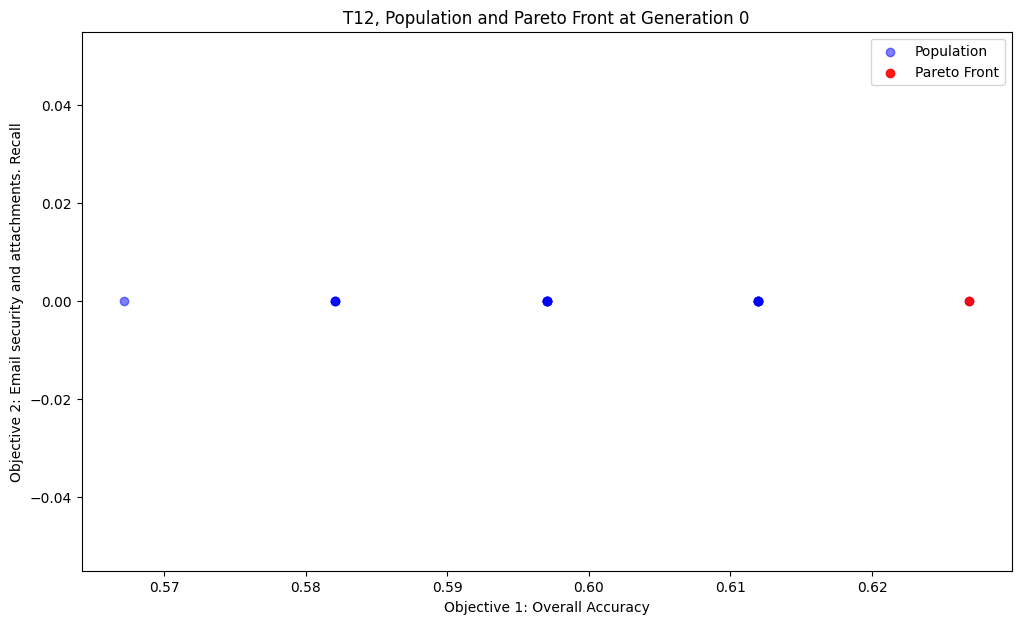

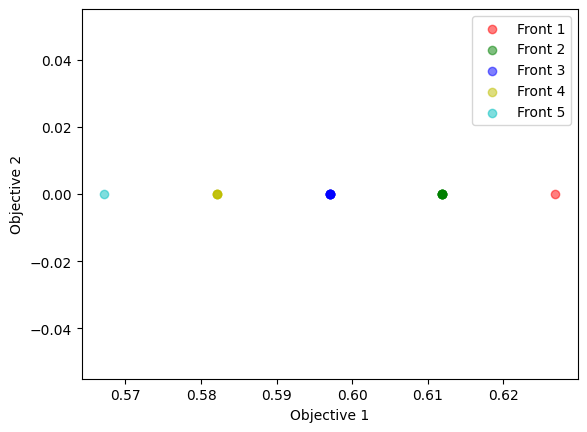

Uniform
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%


Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%


Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%


CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%


(0.8516624040920716, 0.6268656716417911)


CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.8%
Current GPU memory usage: 2.36%


(0.8457480818414322, 0.5970149253731343)


CPU Current memory usage: 1.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.9%
Current GPU memory usage: 2.36%


(0.8430306905370843, 0.6119402985074627)


CPU Current memory usage: 1.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.9%
Current GPU memory usage: 2.36%


(0.8492647058823529, 0.6119402985074627)


CPU Current memory usage: 1.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.9%
Current GPU memory usage: 2.36%


(0.8465473145780051, 0.6119402985074627)


CPU Current memory usage: 1.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.9%
Current GPU memory usage: 2.36%


(0.8524616368286445, 0.5970149253731343)


CPU Current memory usage: 1.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 1.9%
Current GPU memory usage: 2.36%


(0.8449488491048593, 0.6268656716417911)


CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%


(0.8486253196930946, 0.6119402985074627)


CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%


(0.8519820971867008, 0.5970149253731343)


CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.0%


Current GPU memory usage: 2.36%


(0.8383951406649617, 0.6268656716417911)


CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.0%
Current GPU memory usage: 2.36%


(0.8508631713554987, 0.6119402985074627)


CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%


(0.8457480818414322, 0.6119402985074627)


CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%


Current GPU memory usage: 2.36%


(0.8441496163682864, 0.6268656716417911)


CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%


(0.8407928388746803, 0.6119402985074627)


CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%


(0.8452685421994884, 0.6119402985074627)


CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%


(0.8508631713554987, 0.6119402985074627)


CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%


(0.8497442455242967, 0.6119402985074627)


CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.1%
Current GPU memory usage: 2.36%


(0.8468670076726342, 0.6119402985074627)


CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%


(0.8531010230179028, 0.6119402985074627)


CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%


(0.8463874680306905, 0.6119402985074627)


CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%


(0.8492647058823529, 0.6119402985074627)


CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%


(0.8489450127877238, 0.5970149253731343)


CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.2%
Current GPU memory usage: 2.36%


(0.8500639386189258, 0.6119402985074627)


CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%


(0.8486253196930946, 0.5970149253731343)


CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%


(0.8463874680306905, 0.5970149253731343)


CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%


(0.8497442455242967, 0.6119402985074627)


CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.3%
Current GPU memory usage: 2.36%


(0.8491048593350383, 0.6119402985074627)


CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.4%


Current GPU memory usage: 2.36%


(0.8491048593350383, 0.6119402985074627)


CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%


(0.8465473145780051, 0.5970149253731343)


CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%


(0.8414322250639387, 0.5970149253731343)


CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%


(0.8436700767263428, 0.6119402985074627)


CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%


(0.8439897698209718, 0.6119402985074627)


CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%


(0.8499040920716112, 0.6268656716417911)


CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.4%
Current GPU memory usage: 2.36%


(0.8497442455242967, 0.6119402985074627)


CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%


(0.8483056265984654, 0.6119402985074627)


CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%


(0.8508631713554987, 0.6119402985074627)


CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%


(0.8465473145780051, 0.6119402985074627)


CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%


(0.8428708439897699, 0.6268656716417911)


CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.5%
Current GPU memory usage: 2.36%


(0.8427109974424553, 0.6119402985074627)


CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%


(0.8495843989769821, 0.6119402985074627)


CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%


(0.8441496163682864, 0.5970149253731343)


CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%


(0.8468670076726342, 0.6119402985074627)


CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%


(0.8478260869565217, 0.6119402985074627)


CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%


(0.850383631713555, 0.6268656716417911)


CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%


(0.8462276214833759, 0.6119402985074627)


CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.6%
Current GPU memory usage: 2.36%


(0.8465473145780051, 0.6119402985074627)


CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%


(0.8494245524296675, 0.6119402985074627)


CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%


(0.8441496163682864, 0.5970149253731343)


CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%


(0.8471867007672634, 0.5970149253731343)


CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%


Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%


(0.8513427109974424, 0.6119402985074627)


CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%


(0.8491048593350383, 0.582089552238806)


CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.7%
Current GPU memory usage: 2.36%


(0.8476662404092071, 0.6268656716417911)


CPU Current memory usage: 2.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.8%
Current GPU memory usage: 2.36%


(0.847346547314578, 0.5970149253731343)


CPU Current memory usage: 2.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.8%
Current GPU memory usage: 2.36%


(0.8505434782608695, 0.6119402985074627)


CPU Current memory usage: 2.8%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.8%
Current GPU memory usage: 2.36%


(0.8492647058823529, 0.5970149253731343)


CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%


(0.8526214833759591, 0.6119402985074627)


CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%


(0.8523017902813299, 0.6119402985074627)


CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%


(0.8513427109974424, 0.5970149253731343)


CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%


(0.847346547314578, 0.5970149253731343)


CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 2.9%
Current GPU memory usage: 2.36%


(0.8471867007672634, 0.5970149253731343)


CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%


Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%


(0.8471867007672634, 0.6119402985074627)


CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%


(0.8457480818414322, 0.6119402985074627)


CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%


(0.8508631713554987, 0.5970149253731343)


CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%


(0.8494245524296675, 0.5970149253731343)


CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.0%
Current GPU memory usage: 2.36%


(0.8452685421994884, 0.6268656716417911)


CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%


(0.851502557544757, 0.6119402985074627)


CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%


(0.8513427109974424, 0.6119402985074627)


CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.1%


Current GPU memory usage: 2.36%
CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%


(0.850383631713555, 0.582089552238806)


CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.1%
Current GPU memory usage: 2.36%


(0.8460677749360613, 0.5970149253731343)


CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%


(0.84846547314578, 0.5970149253731343)


CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%


(0.847346547314578, 0.5970149253731343)


CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%


(0.8499040920716112, 0.5970149253731343)


CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%


(0.845428388746803, 0.5970149253731343)


CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%


(0.8463874680306905, 0.5970149253731343)


CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.2%
Current GPU memory usage: 2.36%


(0.8491048593350383, 0.5970149253731343)


CPU Current memory usage: 3.3%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.3%
Current GPU memory usage: 2.36%


(0.8495843989769821, 0.6119402985074627)


CPU Current memory usage: 3.3%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.3%
Current GPU memory usage: 2.36%


(0.845428388746803, 0.6119402985074627)


CPU Current memory usage: 3.3%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.3%
Current GPU memory usage: 2.36%


(0.8487851662404092, 0.6119402985074627)


CPU Current memory usage: 3.3%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.3%
Current GPU memory usage: 2.36%


(0.8513427109974424, 0.6119402985074627)


CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%


(0.8441496163682864, 0.6268656716417911)


CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%


CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%


(0.8499040920716112, 0.6268656716417911)


CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%


(0.8483056265984654, 0.6119402985074627)


CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%


(0.8489450127877238, 0.6119402985074627)


CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.4%
Current GPU memory usage: 2.36%


(0.8467071611253197, 0.6119402985074627)


CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%


(0.8457480818414322, 0.6119402985074627)


CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%


(0.8499040920716112, 0.5970149253731343)


CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%


(0.8476662404092071, 0.6119402985074627)


CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.5%
Current GPU memory usage: 2.36%


(0.8406329923273658, 0.582089552238806)


CPU Current memory usage: 3.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.6%
Current GPU memory usage: 2.36%
316
CPU Current memory usage: 3.6%
Current GPU memory usage: 2.36%


(0.8475063938618926, 0.5970149253731343)


CPU Current memory usage: 3.6%
Current GPU memory usage: 2.36%
CPU Current memory usage: 3.6%
Current GPU memory usage: 2.36%


(0.8516624040920716, 0.6119402985074627)


CPU Current memory usage: 3.6%
Current GPU memory usage: 2.36%


(0.8499040920716112, 0.5970149253731343)


CPU Current memory usage: 3.6%
Current GPU memory usage: 2.36%


(0.845108695652174, 0.6268656716417911)


CPU Current memory usage: 3.7%
Current GPU memory usage: 2.36%


(0.8470268542199488, 0.6119402985074627)


CPU Current memory usage: 3.7%
Current GPU memory usage: 2.36%


(0.8489450127877238, 0.5970149253731343)


CPU Current memory usage: 3.7%
Current GPU memory usage: 2.36%


(0.8444693094629157, 0.6119402985074627)


CPU Current memory usage: 3.7%
Current GPU memory usage: 2.36%


(0.8460677749360613, 0.6119402985074627)


CPU Current memory usage: 3.7%
Current GPU memory usage: 2.36%


(0.8463874680306905, 0.6268656716417911)


CPU Current memory usage: 3.7%
Current GPU memory usage: 2.36%


(0.8481457800511509, 0.5970149253731343)


CPU Current memory usage: 3.7%
Current GPU memory usage: 2.36%


(0.8463874680306905, 0.5970149253731343)


CPU Current memory usage: 3.8%
Current GPU memory usage: 2.36%


(0.842071611253197, 0.6119402985074627)


CPU Current memory usage: 3.8%
Current GPU memory usage: 2.36%


(0.8479859335038363, 0.6119402985074627)


CPU Current memory usage: 3.8%
Current GPU memory usage: 2.36%


(0.8489450127877238, 0.6119402985074627)


CPU Current memory usage: 3.8%
Current GPU memory usage: 2.36%


(0.8444693094629157, 0.5970149253731343)


CPU Current memory usage: 3.8%
Current GPU memory usage: 2.36%


(0.8489450127877238, 0.5970149253731343)


CPU Current memory usage: 3.8%
Current GPU memory usage: 2.36%


(0.8449488491048593, 0.6119402985074627)


CPU Current memory usage: 3.9%
Current GPU memory usage: 2.36%


(0.8523017902813299, 0.6119402985074627)


CPU Current memory usage: 3.9%
Current GPU memory usage: 2.36%


(0.8452685421994884, 0.6268656716417911)


CPU Current memory usage: 3.9%
Current GPU memory usage: 2.36%


(0.8487851662404092, 0.6417910447761194)


CPU Current memory usage: 4.0%
Current GPU memory usage: 2.36%


(0.8471867007672634, 0.5970149253731343)


CPU Current memory usage: 4.0%
Current GPU memory usage: 2.36%


(0.8556585677749361, 0.5970149253731343)


CPU Current memory usage: 4.0%
Current GPU memory usage: 2.36%


(0.8452685421994884, 0.6119402985074627)


CPU Current memory usage: 4.0%
Current GPU memory usage: 2.36%


(0.847346547314578, 0.6268656716417911)


CPU Current memory usage: 4.0%
Current GPU memory usage: 2.36%


(0.8505434782608695, 0.6119402985074627)


CPU Current memory usage: 4.1%
Current GPU memory usage: 2.36%


(0.8486253196930946, 0.6268656716417911)


CPU Current memory usage: 4.1%
Current GPU memory usage: 2.36%


(0.8479859335038363, 0.5970149253731343)


CPU Current memory usage: 4.1%
Current GPU memory usage: 2.36%


(0.8479859335038363, 0.6268656716417911)


CPU Current memory usage: 4.1%
Current GPU memory usage: 2.36%


(0.8489450127877238, 0.6268656716417911)


CPU Current memory usage: 4.1%
Current GPU memory usage: 2.36%


(0.8479859335038363, 0.5970149253731343)


CPU Current memory usage: 4.1%
Current GPU memory usage: 2.36%


(0.8470268542199488, 0.5970149253731343)


CPU Current memory usage: 4.2%
Current GPU memory usage: 2.36%


(0.8481457800511509, 0.5970149253731343)


CPU Current memory usage: 4.2%
Current GPU memory usage: 2.36%


(0.8523017902813299, 0.6119402985074627)


CPU Current memory usage: 4.2%
Current GPU memory usage: 2.36%


(0.8529411764705882, 0.6119402985074627)


CPU Current memory usage: 4.3%
Current GPU memory usage: 2.36%


(0.8494245524296675, 0.5970149253731343)


CPU Current memory usage: 4.3%
Current GPU memory usage: 2.36%


(0.8513427109974424, 0.5970149253731343)


CPU Current memory usage: 4.3%
Current GPU memory usage: 2.36%


(0.8502237851662404, 0.6119402985074627)


CPU Current memory usage: 4.3%
Current GPU memory usage: 2.36%


(0.8471867007672634, 0.6119402985074627)


CPU Current memory usage: 4.3%
Current GPU memory usage: 2.36%


(0.8478260869565217, 0.6119402985074627)


CPU Current memory usage: 4.3%
Current GPU memory usage: 2.36%


(0.8510230179028133, 0.6268656716417911)


CPU Current memory usage: 4.4%
Current GPU memory usage: 2.36%


(0.8494245524296675, 0.6417910447761194)


CPU Current memory usage: 4.4%
Current GPU memory usage: 2.36%


(0.8491048593350383, 0.5970149253731343)


CPU Current memory usage: 4.4%
Current GPU memory usage: 2.36%


(0.845428388746803, 0.6119402985074627)


CPU Current memory usage: 4.4%
Current GPU memory usage: 2.36%


(0.84846547314578, 0.6268656716417911)


CPU Current memory usage: 4.4%
Current GPU memory usage: 2.36%


(0.8510230179028133, 0.6268656716417911)


CPU Current memory usage: 4.5%
Current GPU memory usage: 2.36%


(0.850383631713555, 0.6119402985074627)


CPU Current memory usage: 4.5%
Current GPU memory usage: 2.36%


(0.8524616368286445, 0.5970149253731343)


CPU Current memory usage: 4.5%
Current GPU memory usage: 2.36%


(0.8455882352941176, 0.6268656716417911)


CPU Current memory usage: 4.5%
Current GPU memory usage: 2.36%


(0.8476662404092071, 0.6268656716417911)


CPU Current memory usage: 4.6%
Current GPU memory usage: 2.36%


(0.8446291560102301, 0.6268656716417911)


CPU Current memory usage: 4.6%
Current GPU memory usage: 2.36%


(0.8513427109974424, 0.6119402985074627)


CPU Current memory usage: 4.6%
Current GPU memory usage: 2.36%


(0.8526214833759591, 0.6119402985074627)


CPU Current memory usage: 4.6%
Current GPU memory usage: 2.36%


(0.8475063938618926, 0.5970149253731343)


CPU Current memory usage: 4.6%
Current GPU memory usage: 2.36%


(0.8438299232736572, 0.6119402985074627)


CPU Current memory usage: 4.6%
Current GPU memory usage: 2.36%


(0.8374360613810742, 0.6119402985074627)


CPU Current memory usage: 4.7%
Current GPU memory usage: 2.36%


(0.84846547314578, 0.5970149253731343)


CPU Current memory usage: 4.7%
Current GPU memory usage: 2.36%


(0.8439897698209718, 0.6119402985074627)


CPU Current memory usage: 4.7%
Current GPU memory usage: 2.36%


(0.8505434782608695, 0.6119402985074627)


CPU Current memory usage: 4.7%
Current GPU memory usage: 2.36%


(0.8468670076726342, 0.6119402985074627)


CPU Current memory usage: 4.7%
Current GPU memory usage: 2.36%


(0.845428388746803, 0.6119402985074627)


CPU Current memory usage: 4.7%
Current GPU memory usage: 2.36%


(0.8462276214833759, 0.5970149253731343)


CPU Current memory usage: 4.7%
Current GPU memory usage: 2.36%


(0.8492647058823529, 0.6268656716417911)


CPU Current memory usage: 4.9%
Current GPU memory usage: 2.36%


(0.847346547314578, 0.5970149253731343)


CPU Current memory usage: 5.0%
Current GPU memory usage: 2.36%


(0.850383631713555, 0.6119402985074627)


CPU Current memory usage: 5.0%
Current GPU memory usage: 2.36%


(0.8455882352941176, 0.6119402985074627)


CPU Current memory usage: 5.0%
Current GPU memory usage: 2.36%


(0.8481457800511509, 0.6119402985074627)


CPU Current memory usage: 5.1%
Current GPU memory usage: 2.36%


(0.8479859335038363, 0.5970149253731343)


CPU Current memory usage: 5.1%
Current GPU memory usage: 2.36%


(0.8487851662404092, 0.5970149253731343)


CPU Current memory usage: 5.1%
Current GPU memory usage: 2.36%


(0.8505434782608695, 0.6119402985074627)


CPU Current memory usage: 5.1%
Current GPU memory usage: 2.36%


(0.8486253196930946, 0.5970149253731343)


CPU Current memory usage: 5.1%
Current GPU memory usage: 2.36%


(0.8427109974424553, 0.6268656716417911)


CPU Current memory usage: 5.1%
Current GPU memory usage: 2.36%


(0.8481457800511509, 0.6268656716417911)


CPU Current memory usage: 5.2%
Current GPU memory usage: 2.36%


(0.8467071611253197, 0.6119402985074627)


CPU Current memory usage: 5.2%
Current GPU memory usage: 2.36%


(0.8460677749360613, 0.6119402985074627)


CPU Current memory usage: 5.2%
Current GPU memory usage: 2.36%


(0.8460677749360613, 0.5970149253731343)


CPU Current memory usage: 5.2%
Current GPU memory usage: 2.36%


(0.8483056265984654, 0.6268656716417911)


CPU Current memory usage: 5.3%
Current GPU memory usage: 2.36%


(0.842391304347826, 0.5970149253731343)


CPU Current memory usage: 5.3%
Current GPU memory usage: 2.36%


(0.8459079283887468, 0.6268656716417911)


CPU Current memory usage: 5.3%
Current GPU memory usage: 2.36%


(0.8478260869565217, 0.6268656716417911)


CPU Current memory usage: 5.3%
Current GPU memory usage: 2.36%


(0.8513427109974424, 0.6119402985074627)


CPU Current memory usage: 5.3%
Current GPU memory usage: 2.36%


(0.8499040920716112, 0.582089552238806)


CPU Current memory usage: 5.3%
Current GPU memory usage: 2.36%


(0.8502237851662404, 0.6119402985074627)


CPU Current memory usage: 5.4%
Current GPU memory usage: 2.36%
CPU Current memory usage: 5.4%
Current GPU memory usage: 2.36%


(0.8508631713554987, 0.6119402985074627)


CPU Current memory usage: 5.4%
Current GPU memory usage: 2.36%


(0.844309462915601, 0.6119402985074627)


CPU Current memory usage: 5.4%
Current GPU memory usage: 2.36%


(0.8465473145780051, 0.6119402985074627)


CPU Current memory usage: 5.4%
Current GPU memory usage: 2.36%


(0.8505434782608695, 0.5970149253731343)


CPU Current memory usage: 5.4%
Current GPU memory usage: 2.36%


(0.8457480818414322, 0.6119402985074627)


CPU Current memory usage: 5.5%
Current GPU memory usage: 2.36%


(0.8505434782608695, 0.6268656716417911)


CPU Current memory usage: 5.5%
Current GPU memory usage: 2.36%


(0.8414322250639387, 0.6119402985074627)


CPU Current memory usage: 5.5%
Current GPU memory usage: 2.36%


(0.8475063938618926, 0.6119402985074627)


CPU Current memory usage: 5.5%
Current GPU memory usage: 2.36%


(0.8499040920716112, 0.6119402985074627)


CPU Current memory usage: 5.6%
Current GPU memory usage: 2.36%


(0.8471867007672634, 0.5970149253731343)


CPU Current memory usage: 5.6%
Current GPU memory usage: 2.36%


(0.8492647058823529, 0.5970149253731343)


CPU Current memory usage: 5.6%
Current GPU memory usage: 2.36%


(0.8475063938618926, 0.5970149253731343)


CPU Current memory usage: 5.7%
Current GPU memory usage: 2.36%


(0.8492647058823529, 0.6119402985074627)


CPU Current memory usage: 5.7%
Current GPU memory usage: 2.36%


(0.8492647058823529, 0.6119402985074627)


CPU Current memory usage: 5.7%
Current GPU memory usage: 2.36%


(0.8463874680306905, 0.6119402985074627)


CPU Current memory usage: 5.7%
Current GPU memory usage: 2.36%


(0.8523017902813299, 0.5970149253731343)


CPU Current memory usage: 5.7%
Current GPU memory usage: 2.36%


(0.8487851662404092, 0.5970149253731343)


CPU Current memory usage: 5.8%
Current GPU memory usage: 2.36%


(0.8387148337595908, 0.582089552238806)


CPU Current memory usage: 5.8%
Current GPU memory usage: 2.36%


(0.8483056265984654, 0.6119402985074627)


CPU Current memory usage: 5.8%
Current GPU memory usage: 2.36%


(0.8457480818414322, 0.6417910447761194)


CPU Current memory usage: 5.8%
Current GPU memory usage: 2.36%


(0.8455882352941176, 0.5970149253731343)


CPU Current memory usage: 5.8%
Current GPU memory usage: 2.36%


(0.8478260869565217, 0.6119402985074627)


CPU Current memory usage: 5.9%
Current GPU memory usage: 2.36%


(0.8479859335038363, 0.6119402985074627)


CPU Current memory usage: 5.9%
Current GPU memory usage: 2.36%


(0.8476662404092071, 0.6119402985074627)


CPU Current memory usage: 5.9%
Current GPU memory usage: 2.36%


(0.8478260869565217, 0.5970149253731343)


CPU Current memory usage: 5.9%
Current GPU memory usage: 2.36%


(0.844309462915601, 0.6119402985074627)


CPU Current memory usage: 5.9%
Current GPU memory usage: 2.36%


(0.8519820971867008, 0.582089552238806)


CPU Current memory usage: 6.0%
Current GPU memory usage: 2.36%


(0.8438299232736572, 0.6268656716417911)


CPU Current memory usage: 6.0%
Current GPU memory usage: 2.36%


(0.8542199488491049, 0.5970149253731343)


CPU Current memory usage: 6.0%
Current GPU memory usage: 2.36%


(0.8417519181585678, 0.6119402985074627)


CPU Current memory usage: 6.0%
Current GPU memory usage: 2.36%


(0.845428388746803, 0.582089552238806)


CPU Current memory usage: 6.0%
Current GPU memory usage: 2.36%


(0.8505434782608695, 0.6119402985074627)


CPU Current memory usage: 6.0%
Current GPU memory usage: 2.36%


(0.8383951406649617, 0.6119402985074627)


CPU Current memory usage: 6.1%
Current GPU memory usage: 2.36%


(0.8463874680306905, 0.5970149253731343)


CPU Current memory usage: 6.1%
Current GPU memory usage: 2.36%


(0.8455882352941176, 0.6119402985074627)


CPU Current memory usage: 6.1%
Current GPU memory usage: 2.36%


(0.8465473145780051, 0.5970149253731343)


CPU Current memory usage: 6.1%
Current GPU memory usage: 2.36%


(0.8481457800511509, 0.5970149253731343)


CPU Current memory usage: 6.1%
Current GPU memory usage: 2.36%


(0.8467071611253197, 0.6119402985074627)


CPU Current memory usage: 6.1%
Current GPU memory usage: 2.36%


(0.8500639386189258, 0.6119402985074627)


CPU Current memory usage: 6.1%
Current GPU memory usage: 2.36%


(0.8497442455242967, 0.5970149253731343)


CPU Current memory usage: 6.2%
Current GPU memory usage: 2.36%


(0.8455882352941176, 0.5970149253731343)


CPU Current memory usage: 6.2%
Current GPU memory usage: 2.36%


(0.8492647058823529, 0.6119402985074627)


CPU Current memory usage: 6.2%
Current GPU memory usage: 2.36%


(0.8491048593350383, 0.6119402985074627)


CPU Current memory usage: 6.2%
Current GPU memory usage: 2.36%


(0.8468670076726342, 0.6119402985074627)


CPU Current memory usage: 6.2%
Current GPU memory usage: 2.36%


(0.8524616368286445, 0.6268656716417911)


CPU Current memory usage: 6.2%
Current GPU memory usage: 2.36%


(0.8487851662404092, 0.6119402985074627)


CPU Current memory usage: 6.3%
Current GPU memory usage: 2.36%


(0.8516624040920716, 0.6119402985074627)


CPU Current memory usage: 6.3%
Current GPU memory usage: 2.36%


(0.8475063938618926, 0.6119402985074627)


CPU Current memory usage: 6.3%
Current GPU memory usage: 2.36%


(0.8508631713554987, 0.5970149253731343)


CPU Current memory usage: 6.3%
Current GPU memory usage: 2.36%


(0.847346547314578, 0.5970149253731343)


CPU Current memory usage: 6.4%
Current GPU memory usage: 2.36%


(0.8460677749360613, 0.6119402985074627)


CPU Current memory usage: 6.4%
Current GPU memory usage: 2.36%


(0.8455882352941176, 0.6119402985074627)


CPU Current memory usage: 6.4%
Current GPU memory usage: 2.36%


(0.8467071611253197, 0.5970149253731343)


CPU Current memory usage: 6.4%
Current GPU memory usage: 2.36%


(0.8497442455242967, 0.582089552238806)


CPU Current memory usage: 6.4%
Current GPU memory usage: 2.36%


(0.8462276214833759, 0.6268656716417911)


CPU Current memory usage: 6.4%
Current GPU memory usage: 2.36%


(0.8508631713554987, 0.6268656716417911)


CPU Current memory usage: 6.5%
Current GPU memory usage: 2.36%


(0.8457480818414322, 0.5970149253731343)


CPU Current memory usage: 6.5%
Current GPU memory usage: 2.36%


(0.8462276214833759, 0.5970149253731343)


CPU Current memory usage: 6.5%
Current GPU memory usage: 2.36%


(0.840153452685422, 0.5970149253731343)


CPU Current memory usage: 6.5%
Current GPU memory usage: 2.36%


(0.8455882352941176, 0.6119402985074627)


CPU Current memory usage: 6.5%
Current GPU memory usage: 2.36%


(0.8435102301790282, 0.6119402985074627)


CPU Current memory usage: 6.5%
Current GPU memory usage: 2.36%


(0.8487851662404092, 0.6119402985074627)


CPU Current memory usage: 6.5%
Current GPU memory usage: 2.36%


(0.8481457800511509, 0.6119402985074627)


CPU Current memory usage: 6.6%
Current GPU memory usage: 2.36%


(0.8489450127877238, 0.6119402985074627)


CPU Current memory usage: 6.6%
Current GPU memory usage: 2.36%


(0.8468670076726342, 0.6119402985074627)


CPU Current memory usage: 6.6%
Current GPU memory usage: 2.36%


(0.8471867007672634, 0.6119402985074627)


CPU Current memory usage: 6.6%
Current GPU memory usage: 2.36%


(0.8497442455242967, 0.6417910447761194)


CPU Current memory usage: 6.6%
Current GPU memory usage: 2.36%


(0.8404731457800512, 0.5970149253731343)


CPU Current memory usage: 6.7%
Current GPU memory usage: 2.36%


(0.8465473145780051, 0.6119402985074627)


CPU Current memory usage: 6.7%
Current GPU memory usage: 2.36%


(0.8491048593350383, 0.6268656716417911)


CPU Current memory usage: 6.7%
Current GPU memory usage: 2.36%


(0.8500639386189258, 0.6119402985074627)


CPU Current memory usage: 6.7%
Current GPU memory usage: 2.36%


(0.8486253196930946, 0.6119402985074627)


CPU Current memory usage: 6.7%
Current GPU memory usage: 2.36%


(0.8449488491048593, 0.6119402985074627)


CPU Current memory usage: 6.7%
Current GPU memory usage: 2.36%


(0.8476662404092071, 0.6268656716417911)


CPU Current memory usage: 6.8%
Current GPU memory usage: 2.36%


(0.8476662404092071, 0.6119402985074627)


CPU Current memory usage: 6.8%
Current GPU memory usage: 2.36%


(0.8500639386189258, 0.6119402985074627)


CPU Current memory usage: 6.8%
Current GPU memory usage: 2.36%


(0.8471867007672634, 0.6119402985074627)


CPU Current memory usage: 6.8%
Current GPU memory usage: 2.36%


(0.8550191815856778, 0.6119402985074627)


CPU Current memory usage: 6.8%
Current GPU memory usage: 2.36%


(0.843190537084399, 0.6268656716417911)


CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%


(0.8471867007672634, 0.6119402985074627)


CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%


(0.8478260869565217, 0.6268656716417911)


CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%


(0.8500639386189258, 0.6268656716417911)


CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%


Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%
CPU Current memory usage: 6.9%
Current GPU memory usage: 2.36%


                                          precision    recall  f1-score  \
IT support and assistance.                 0.978748  0.974828  0.976784   
Account activation and access issues.      0.912478  0.932271  0.922268   
Password and device security.              0.926454  0.910464  0.918390   
Printer issues and troubleshooting.        0.884615  0.818505  0.850277   
HP Dock connectivity issues.               0.786792  0.782364  0.784572   
Employee documentation and errors.         0.573086  0.662198  0.614428   
"Access and login issues"                  0.757869  0.792405  0.774752   
Opening and managing files/devices.        0.678414  0.652542  0.665227   
Mobile email and VPN setup.                0.610465  0.755396  0.675241   
IT support and communication.              0.568690  0.531343  0.549383   
Error handling in RPG programming.         1.000000  0.946809  0.972678   
Email security and attachments.            0.569231  0.578125  0.573643   
Humanitarian aid for Ukra

In [8]:
if __name__ == "__main__":
    run = 1
    rand = 10
    
    run_path = f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}"
    itr0_path = f"{run_path}/Iteration_0"
    os.makedirs(itr0_path, exist_ok=True)

    # Load Data
    data = pd.read_csv(f'D:/AutoGeTS/Data/tickets_topics.csv',lineterminator='\n')
    data_topic = data.dropna().reset_index()
    data_topic = data_topic.rename(columns={'index': 'index_meta'})

    X_train_r_both, X_test_re_Test, Y_train_r_both, Y_test_re_Test = train_test_split(data_topic, data_topic.topic_name, test_size = 0.2,random_state = 42)
        
    # Further split the training set to create a validation set
    X_train_r, X_test_re, Y_train_r, Y_test_re = train_test_split(
        X_train_r_both, 
        Y_train_r_both, 
        test_size=0.2,  # 20% of the initial training set, which is 16% of the original data
        random_state=rand
    )

    catboost_params = {'iterations': 300, 'learning_rate': 0.2, 'depth': 8, 'l2_leaf_reg': 1, 
                        'bagging_temperature': 1, 'random_strength': 1, 'border_count': 254, 
                        'eval_metric': 'TotalF1', 'task_type': 'GPU', 'early_stopping_rounds': 20, 'use_best_model': True, 'verbose': 0, 'random_seed': rand}

    topic_dict = {"T1": "IT support and assistance.","T2": "Account activation and access issues.","T3": "Password and device security.",
                "T4": "Printer issues and troubleshooting.","T5": "HP Dock connectivity issues.","T6": "Employee documentation and errors.",
                "T7": "\"Access and login issues\"","T8": "Opening and managing files/devices.","T9": "Mobile email and VPN setup.",
                "T10": "IT support and communication.","T11": "Error handling in RPG programming.","T12": "Email security and attachments.",
                "T13": "Humanitarian aid for Ukraine.","T14": "Internet connectivity issues in offices.","T15": "Improving integration with Infojobs.", "Acc": "accuracy"}
    
    bch_dict = train_bch(X_train_r, X_test_re, Y_train_r, Y_test_re, catboost_params, itr0_path)
    for iteration in [2]:
        # if iteration <= 1:
        #     continue
        if iteration == 2:
            topic_number = "T12"
        # elif iteration == 2:
        #     topic_number = "T12"
        # for topic_number in ["T13"]: # "T11", "T15"
        # iteration = 1
        prev_itr = iteration - 1

        with open(f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{prev_itr}/T12_CR_imp_max.pkl", "rb") as file:
            t12_cr_imp_max = pickle.load(file)

        gpu_hours = 1

        if topic_number in []:
            metric_name = "overall_balanced_accuracy" # "recall", "Balanced Accuracy", "overall_balanced_accuracy", "overall_f1-score"
        elif topic_number in ["T1"]:
            metric_name = "overall_f1-score"
        elif topic_number in ["T11", "T13", "T14", "T15"]:
            metric_name = "Balanced Accuracy"
        elif topic_number in ["T12"]:
            metric_name = "recall"

        nsgaii_results_path = f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{iteration}/{topic_number}_{metric_name}_GPU{gpu_hours}h_GA"
        os.makedirs(nsgaii_results_path, exist_ok=True)

        fold_pfs_df = pd.DataFrame() 
        gen_eval_df = pd.DataFrame() 
        gen_pfs_df = pd.DataFrame() 
        test_gen_eval_df = pd.DataFrame() 

        init_counter = 0
        generation_counter = -1
        history_IndexesList_dict = {}
        history_pareto_selections_list = []
        gen_stats_df = pd.DataFrame(columns=["Generation", "Number of Evaluations", "Best Fitness", "Worst Fitness", "Mean Overall Accuracy", "Mean Topic Recall", "Pareto Front Selections"])

        if iteration > 1:
            bch_class_df = pd.read_pickle(f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{prev_itr}/Bch_Itr_{prev_itr}.pkl")
            bch_filtered_columns = [col for col in bch_class_df.columns if not col.startswith("Diff") and col != "Accuracy"]
            bch_class_df = bch_class_df[bch_filtered_columns]
        else:
            bch_class_df = pd.read_pickle(f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_0/Benchmark_M0_Classdf_0.pkl")

        bch_m0 = pd.read_pickle(f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_0/Benchmark_M0_Classdf_0.pkl")
        
        if iteration > 1:
            prev_itr_X_train_re = pd.read_pickle(f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{prev_itr}/X_train_re_itr_{prev_itr}.pkl")
            X_train_r = prev_itr_X_train_re
            prev_itr_Y_train_re = pd.read_pickle(f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{prev_itr}/Y_train_re_itr_{prev_itr}.pkl")
            Y_train_r = prev_itr_Y_train_re
        
        low_recall_topics_order = [["Acc", "T13"], ["T15", "T12", "T10", "T14"], ["T6", "T8", "T9", "T7", "T5", "T4"], ["T3", "T2", "T11", "T1"]]
        large_size_topics_order = [["Acc"], ["T2", "T1", "T3"], ["T5", "T7", "T6", "T10", "T4", "T9", "T8"], ["T14", "T15", "T11", "T12", "T13"]]
        topic_group_probabilities = [0.4, 0.3, 0.2, 0.1]
        topic_name_cases_order = [[topic_dict[topic_number] for topic_number in sublist] for sublist in low_recall_topics_order]
        topic_name_sizes_order = [[topic_dict[topic_number] for topic_number in sublist] for sublist in large_size_topics_order]


        """Section below are changable parameters/inputs----------------------------"""
        # topic_number = "T13"
        syn_number = 1

        total_gpu_seconds = gpu_hours * 60 * 60
        
        # Added synthetic data path
        if topic_number in ["T1", "T2"]:
            data_syn_raw = pd.read_pickle(f'D:/AutoGeTS/Synthetic_Data/{topic_number}-synthesis-{syn_number}.pkl')
        else:
            data_syn_raw = pd.read_csv(f'D:/AutoGeTS/Synthetic_Data/{topic_number}-synthesis-{syn_number}.csv',lineterminator='\n')
        data_syn = data_syn_raw[["index_meta", "text", "area_TEIS", 'topic_name', "sample"]].dropna()

        Xmode = "" # "", "Xnp"
        Smode = "Sovl"
        population_size = 20
        num_selected = 20
        max_generations = 15
        tournament_size = 3
        crossover_rate = 0.7
        initial_mutation_rate = 0.3
        maximize=True

        NSGA_II_results_name = f"{topic_number}_{Xmode}_LexClS-{Smode}_PopSize{population_size}_NumSel{num_selected}_MaxGen{max_generations}_CR{crossover_rate}_MR{initial_mutation_rate}"
        gen_stats_df_name = f"NSGAII-Gen-Stats_{topic_number}_{Xmode}_LexClS-{Smode}_PopSize{population_size}_NumSel{num_selected}_MaxGen{max_generations}_CR{crossover_rate}_MR{initial_mutation_rate}"
        history_dict_name = f"NSGAII-Retrain-Dict_{topic_number}_{Xmode}_LexClS-{Smode}_PopSize{population_size}_NumSel{num_selected}_MaxGen{max_generations}_CR{crossover_rate}_MR{initial_mutation_rate}"
        final_pop_name = f"NSGAII-FinalPop_{topic_number}_{Xmode}_LexClS-{Smode}_PopSize{population_size}_NumSel{num_selected}_MaxGen{max_generations}_CR{crossover_rate}_MR{initial_mutation_rate}"
        history_pareto_lists_name = f"NSGAII-HistoryPareto-List_{topic_number}_{Xmode}_LexClS-{Smode}_PopSize{population_size}_NumSel{num_selected}_MaxGen{max_generations}_CR{crossover_rate}_MR{initial_mutation_rate}"
        
        # catboost_params = {'iterations': 300, 'learning_rate': 0.2, 'depth': 6, 'l2_leaf_reg': 1, 
        #                    'bagging_temperature': 1, 'random_strength': 1, 'border_count': 254, 
        #                    'eval_metric': 'TotalF1', 'task_type': 'GPU', 'early_stopping_rounds': 20, 'use_best_model': True, 'verbose': 1, 'random_seed': 0}

        # catboost_params = {'iterations': 300, 'learning_rate': 0.2, 'depth': 8, 'l2_leaf_reg': 3, 
        #                    'bagging_temperature': 1, 'random_strength': 1, 'border_count': 254, 
        #                    'eval_metric': 'TotalF1', 'task_type': 'GPU', 'early_stopping_rounds': 20, 'use_best_model': True, 'verbose': 1, 'random_seed': 0}

        # catboost_params = {'iterations': 300, 'learning_rate': 0.5, 'depth': 6, 'l2_leaf_reg': 10, 
        #                    'bagging_temperature': 1, 'random_strength': 1, 'border_count': 254, 
        #                    'eval_metric': 'TotalF1', 'task_type': 'GPU', 'early_stopping_rounds': 20, 'use_best_model': True, 'verbose': 1, 'random_seed': 0}

        """-----------------------------------"""

        topic_name = topic_dict[topic_number]
        clean_topic_name = clean_folder_name(topic_name)

        sum_GPU_seconds = 0
        GPU_limit = False

        class_data_pool = X_train_r[X_train_r['topic_name'] == topic_name]
        class_index_meta_pool = class_data_pool['index_meta'].tolist()

        args={"data_syn": data_syn,
            "max_generations": max_generations,
            "num_selected": num_selected,  # Or another suitable size
            "crossover_rate": crossover_rate,
            "initial_mutation_rate": initial_mutation_rate,
            "class_index_meta_pool": class_index_meta_pool,
                }


        final_pop = run_nsga2(args, population_size=population_size, maximize=maximize, max_generations=max_generations, num_selected=num_selected, seed=42)
        if GPU_limit == True:
            gen_eval_df  = find_pareto_front(gen_eval_df)
            gen_eval_df = find_best_values(gen_eval_df)
            gen_eval_df = post_process(gen_eval_df, bch_class_df)
            gen_eval_df.to_csv(f'{nsgaii_results_path}/GenAllEvals_{NSGA_II_results_name}.csv', index=True)
            gen_eval_df.to_pickle(f'{nsgaii_results_path}/GenAllEvals_{NSGA_II_results_name}.pkl')
            # break
            test_gen_eval_df  = find_pareto_front(test_gen_eval_df)
            test_gen_eval_df = find_best_values(test_gen_eval_df)
            test_gen_eval_df = post_process(test_gen_eval_df, bch_class_df)
            test_gen_eval_df.to_csv(f'{nsgaii_results_path}/test_GenAllEvals_{NSGA_II_results_name}.csv', index=True)
            test_gen_eval_df.to_pickle(f'{nsgaii_results_path}/test_GenAllEvals_{NSGA_II_results_name}.pkl')
            # break
        
        iteration_repo = f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{iteration}/"
        no_improve_repo = os.path.join(iteration_repo, "Itr_No_Improve")

        os.makedirs(iteration_repo, exist_ok=True)  # Always need iteration_repo
        
        def store_classification_df(df, repo_path, iteration):
            """Helper to store classification DataFrame in CSV/PKL format."""
            csv_path = os.path.join(repo_path, f"Bch_Itr_{iteration}.csv")
            pkl_path = os.path.join(repo_path, f"Bch_Itr_{iteration}.pkl")
            df.to_csv(csv_path, index=True)
            df.to_pickle(pkl_path)

        def store_xy_data(X, Y, repo_path, iteration):
            """Helper to store X_train_re/Y_train_re in PKL format."""
            X_path = os.path.join(repo_path, f"X_train_re_itr_{iteration}.pkl")
            Y_path = os.path.join(repo_path, f"Y_train_re_itr_{iteration}.pkl")
            X.to_pickle(X_path)
            Y.to_pickle(Y_path)

        """Extract best model and append synthetics"""
        # # Find the index of the row with the largest value in the 'max_overall_balanced_acc_imp' column
        # index_of_max_imp = test_gen_eval_df['T12_CR_Imp'].idxmax()
        # print(index_of_max_imp)

        # # Retrieve the row corresponding to this index
        # row_with_largest_value = test_gen_eval_df.loc[index_of_max_imp]

        constrained_df = test_gen_eval_df[
            (test_gen_eval_df['T12_CR_Imp'] >= 0) & 
            (test_gen_eval_df['T7_CR_Imp'] >= 0) & 
            (test_gen_eval_df['OF1_Imp'] >= 0)
        ]

        if constrained_df.empty:
            # Create the "constrained_df_empty" folder
            empty_folder_path = os.path.join(iteration_repo, "constrained_df_empty")
            os.makedirs(empty_folder_path, exist_ok=True)
            
            # If there's no row that satisfies the requirement,
            # then we do the "no improvement" logic:
            store_classification_df(bch_class_df, iteration_repo, iteration)
            store_xy_data(prev_itr_X_train_re, prev_itr_Y_train_re, iteration_repo, iteration)

            with open(f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{iteration}/T12_CR_imp_max.pkl", "wb") as file:
                pickle.dump(t12_cr_imp_max, file)
            
        else:
            # Sort descending by T12_CR_Imp, then topic_balanced_accuracy, then overall_balanced_accuracy
            sorted_df = constrained_df.sort_values(
                by=["Super_Obj_T12T7_CR", "T12_CR_Imp", "Super_Obj_T12T7_CBA", "overall_balanced_accuracy"],
                ascending=False
            )

            # Pick the first row from the sorted DataFrame
            row_with_largest_value = sorted_df.iloc[0]

            largest_value = row_with_largest_value["T12_CR_Imp"]
            if t12_cr_imp_max < largest_value:
                t12_cr_imp_max = largest_value
            
            with open(f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{iteration}/T12_CR_imp_max.pkl", "wb") as file:
                pickle.dump(t12_cr_imp_max, file)

            filtered_syn_df = data_syn[data_syn['index_meta'].isin(row_with_largest_value['retrained_dots_list'])]

            X_train_re = pd.concat([X_train_r, filtered_syn_df.drop(columns=['topic_name'])])
            Y_train_re = pd.concat([Y_train_r, filtered_syn_df['topic_name']])

            train_pool_re = Pool(
                X_train_re[["text", "area_TEIS"]],
                Y_train_re,
                text_features=["text"],
                cat_features=["area_TEIS"]
            )
            valid_pool_re = Pool(
                X_test_re[["text", "area_TEIS"]],
                Y_test_re,
                text_features=["text"],
                cat_features=["area_TEIS"]
            )

            catboost_params = catboost_params
                        
            # Model Training
            model_re = CatBoostClassifier(**catboost_params)
            # start_time = time.time()  # Start timing
            model_re.fit(train_pool_re, eval_set=valid_pool_re)
            # training_time = time.time() - start_time  # End timing

            # Save the retrain performances
            predictions = model_re.predict(X_test_re_Test[["text", "area_TEIS"]])
            accuracy = accuracy_score(Y_test_re_Test, predictions)
            report = classification_report(Y_test_re_Test, predictions, digits=6, output_dict=True)
            classification_df = classification_report_to_df(report, Y_test_re_Test, predictions)

            print(classification_df)

            def store_classification_df(df, repo_path, iteration):
                """Helper to store classification DataFrame in CSV/PKL format."""
                csv_path = os.path.join(repo_path, f"Bch_Itr_{iteration}.csv")
                pkl_path = os.path.join(repo_path, f"Bch_Itr_{iteration}.pkl")
                df.to_csv(csv_path, index=True)
                df.to_pickle(pkl_path)

            def store_xy_data(X, Y, repo_path, iteration):
                """Helper to store X_train_re/Y_train_re in PKL format."""
                X_path = os.path.join(repo_path, f"X_train_re_itr_{iteration}.pkl")
                Y_path = os.path.join(repo_path, f"Y_train_re_itr_{iteration}.pkl")
                X.to_pickle(X_path)
                Y.to_pickle(Y_path)

            # --- Your main code ---
            iteration_repo = f"D:/Ensemble_Multi_Objective/MultiObj_Ensemble_C12C7_CR_A/A_Run_{run}/Iteration_{iteration}/"
            no_improve_repo = os.path.join(iteration_repo, "Itr_No_Improve")

            os.makedirs(iteration_repo, exist_ok=True)  # Always need iteration_repo

            # Compute the metrics just once
            diff_recall_mean = (
                classification_df.loc[topic_dict["T12"], 'Diff recall']
                + classification_df.loc[topic_dict["T7"], 'Diff recall']
            ) / 2

            diff_bal_acc_mean = (
                classification_df.loc[topic_dict["T12"], 'Diff Balanced Accuracy']
                + classification_df.loc[topic_dict["T7"], 'Diff Balanced Accuracy']
            ) / 2

            diff_f1_accuracy = classification_df.loc["accuracy", 'Diff f1-score']

            # Decide if "improved" or "no improvement"
            #  -- Condition from your code:
            #     A) diff_recall_mean > 0
            #     B) diff_recall_mean == 0 and (diff_bal_acc_mean > 0 or diff_f1_accuracy > 0)
            #     Otherwise, no improvement
            improved = False
            if diff_recall_mean > 0:
                improved = True
            elif diff_recall_mean == 0:
                if (diff_bal_acc_mean > 0) or (diff_f1_accuracy > 0):
                    improved = True

            if improved:
                # Same saving logic for improved scenario
                store_classification_df(classification_df, iteration_repo, iteration)
                store_xy_data(X_train_re, Y_train_re, iteration_repo, iteration)
            else:
                # No improvement scenario
                os.makedirs(no_improve_repo, exist_ok=True)
                # Save classification_df to the no-improve repo
                store_classification_df(classification_df, no_improve_repo, iteration)
                store_xy_data(X_train_re, Y_train_re, no_improve_repo, iteration)

                # Also save bch_class_df and previous iteration's data to iteration_repo
                store_classification_df(bch_class_df, iteration_repo, iteration)
                store_xy_data(prev_itr_X_train_re, prev_itr_Y_train_re, iteration_repo, iteration)
            # with open(f'{nsgaii_results_path}/{history_dict_name}.pkl', 'wb') as file:
            #     pickle.dump(history_IndexesList_dict, file)

            # with open(f'{nsgaii_results_path}/{final_pop_name}.pkl', 'wb') as file:
            #     pickle.dump(final_pop, file)

            # with open(f'{nsgaii_results_path}/{history_pareto_lists_name}.pkl', 'wb') as file:
            #     pickle.dump(history_pareto_selections_list, file)
            
            # gen_stats_df = all_pareto_observer(history_pareto_selections_list)
                